# Analysis Code for _Frequency, Acceptability, and Selection_

[Aaron Steven White](http://aaronstevenwhite.io)<br/> 
_University of Rochester_<br/>
`aaron.white@rochester.edu`<br/>
_Last Updated:_ 2 Sep 2020

This notebook contains all of the analyses from: 

> White, A.S. and K. Rawlins. 2020. [Frequency, acceptability, and selection: A case study of clause-embedding](https://ling.auf.net/lingbuzz/004596/current.pdf). Accepted to _Glossa_.

If you use any of the code found in this directory, please cite that
paper as well as [this repository](https://github.com/MegaAttitude/frequency-acceptability-selection.git).

## Notebook Contents

Code relevant to each of the following sections can be jumped to using the links below.

- [Section 3 and Appendix B](#Validation-Experiments)
- [Section 4 and Appendices A and C](#The-MegaAcceptability-Dataset)
- [Section 5](#Relating-Frequency-and-Acceptability)
- [Section 6](#Abstracting-Frequency)
- [Appendix D](#Single-Verb)

These links will not work when viewing this notebook on github.

## Environment Setup

It is strongly recommended that you run this notebook using the docker image it is shipped with. See the README shipped with this notebook for details. The relevant Dockerfile is duplicated below.

```
FROM jupyter/datascience-notebook:cfddc5a3163f

LABEL maintainer.name="Aaron Steven White" \
      maintainer.email="aaron.white@rochester.edu" \
      maintainer.website="http://aaronstevenwhite.io" \
      project.name="MegaAttitude" \
      project.website="http://megaattitude.io" \
      subproject.name="MegaAcceptability" \
      subproject.name="http://megaattitude.io/projects/mega-acceptability/" \
      image.website="https://github.com/MegaAttitude/frequency-acceptability-selection" \
      image.version="1.1" \
      image.modification_date="2020-09-02"

COPY --chown=1000:100 ./*.ipynb /home/jovyan/work/

VOLUME /home/jovyan/work/

RUN mkdir data && mkdir plots

RUN pip install timeout-decorator==0.4.0\
		tensorflow==1.4.1\
		torch==1.0.1\
		pytorch-pretrained-bert==0.6.2

RUN R -e "install.packages(c('tidyverse', 'reshape2', 'lme4', 'ggrepel'), repos='http://cran.us.r-project.org')"
```

Failure to use this docker image could result in minor differences in statistics from the published paper or inability to run the code at all due to API changes.

In [1]:
import os
import re
import random
import pickle
import io
import tarfile
import zipfile
import bz2
import requests
import timeout_decorator

import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf
import torch

from collections import defaultdict
from sklearn.model_selection import KFold
from scipy.stats import spearmanr

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import LatentDirichletAllocation
from pytorch_pretrained_bert import BertTokenizer, BertModel

import matplotlib.pyplot as plt
%matplotlib inline

import rpy2
%load_ext rpy2.ipython

All the data needed for the analyses in this notebook are downloaded at run time, so an internet connection is also required.

## Normalization Models

Because we collect acceptability judgments using likert scale experiments, we need to normalize each annotator's responses prior to analysis. We do this using an ordinal model-based normalizer implemented in `tensorflow`. This method is discussed in Appendices B and C of the paper.

In [2]:
def fit_normalizer(response, obj, participant, weights=None, smoothing=1., 
                   iterations=25000, verbose=1000, seed=204938):
    """Fit an ordinal normalizer
    
    Parameters
    ----------
    response: pandas.Series[int]
        The ordinal responses
    obj: pandas.Series[int]
        The objects the ordinal responses were assigned to
    participant: pandas.Series[int]
        The participant that provided each ordinal response
    weights: pandas.Series[float]
        The weight to assign to each response
    smoothing: float
        The pseudocount of responses below and above the midpoint to smooth with
    iterations: int
        The number of iterations to run the normalizer
    verbose: int
        The interval between iterations
    seed: int
        The random seed
        
    Returns
    -------
    normed_obj: numpy.array[float]
        The normalized values
    likes_all: numpy.array[float]
        The likelihood of the ordinal response
    jumps: numpy.array[float]
        The distances between cutpoints for each participant
    cuts_shifted: numpy.array[float]
        The cutpoints for each participant
    """
    # the total number of responses
    n = response.shape[0]
    
    # convert the input data to tf constants
    resp_tf = tf.constant(np.array(list(zip(np.arange(n), 
                                            response.astype(np.int32)))))
    obj_tf = tf.constant(obj.astype(np.int32))
    part_tf = tf.constant(participant.astype(np.int32))
    
    # the number of responds, participants, and objects
    nresp = np.unique(response).shape[0]
    npart = np.unique(participant).shape[0]
    nobj = np.unique(obj).shape[0]
    
    # initialize the normalized values
    normed = tf.Variable(tf.random_normal([nobj], 
                                          0, 1e-5, 
                                          seed=seed))
    normed_obj = tf.gather(normed, obj_tf)
    
    # initialize the distances between cutpoints for each participant
    jumps_aux = tf.Variable(tf.random_normal([npart, nresp-1], 
                                             0, 1e-5, 
                                             seed=seed+1))
    jumps = tf.square(jumps_aux)
    
    # find the middle of the ordinal scale
    mid = np.floor(nresp/2).astype(int)
    
    # compute the cutpoints from the distances between them
    cuts = tf.cumsum(jumps, axis=1)
    cuts_mean = tf.reduce_mean(cuts, axis=0)
    cuts_shifted = cuts - cuts_mean[mid]
    cuts_part = tf.gather(cuts_shifted, part_tf)
    
    # compute the log probabilities for each response
    prob_leq = tf.sigmoid(cuts_part-normed_obj[:,None])
    
    prob_leq_high = tf.concat([prob_leq, tf.ones([n, 1])], axis=1)
    prob_leq_low = tf.concat([tf.zeros([n, 1]), prob_leq], axis=1)
    
    probs = tf.gather_nd(prob_leq_high, resp_tf) - tf.gather_nd(prob_leq_low, resp_tf)
    
    # compute the prior log probability (random effects loss)
    jumps_norm = jumps/tf.reduce_mean(jumps, axis=0)[None,:]
    prior = tf.reduce_sum(jumps_norm)
    
    # weight the likelihood by the weights if provided
    if weights is not None:  
        weights_tf = tf.constant(weights.astype(np.float32))
        
        likes_all = weights_tf*tf.log(probs+1e-10)
        like = -tf.reduce_sum(likes_all)
    else:
        likes_all = tf.log(probs+1e-10)
        like = -tf.reduce_sum(likes_all)
    
    # apply the smoothing if non-zero
    if smoothing:
        cuts_mean = tf.reduce_mean(cuts_shifted, axis=0)
        prob_leq_mean = tf.sigmoid(cuts_mean[mid]-normed)
        like_smoothed = like -\
                        tf.reduce_sum(smoothing*tf.log(prob_leq_mean)+\
                                      smoothing*tf.log(1-prob_leq_mean))
    
        loss = like_smoothed+prior
    else:
        loss = like+prior
    
    # initialize the optimizer
    optimizer = tf.train.AdamOptimizer(0.1)

    train_op = optimizer.minimize(loss)

    sess.run(tf.global_variables_initializer())
    
    grads_and_vars = optimizer.compute_gradients(loss)
    
    # run the optimization
    for i in range(iterations):
        _, lk, pr, l, p = sess.run([train_op, like, prior, loss, probs])
        if not i % verbose:
            print('iteration:', ' '*9, i)
            print('likelihood:', ' '*8, np.round(lk, 3))
            print('prior:', ' '*13, np.round(pr, 3)) 
            print('loss:', ' '*14, np.round(l, 3))
            print('mean probability:', ' '*2, np.round(p.mean(), 3))
            print()
            
    return normed_obj.eval(), likes_all.eval(), jumps.eval(), cuts_shifted.eval()

# Validation Experiments

Section 3 of the paper presents a pair of datasets aimed at validating the bleaching method proposed in the paper. The first dataset is a standard likert scale acceptability judgment dataset collected by [White et al. (2018)](https://onlinelibrary.wiley.com/doi/full/10.1111/cogs.12512). The second is a replication of White et al. collected for the current analysis using the bleaching method. 

## White et al. 2018

White et al.'s acceptability judgment dataset can be found in [`aaronstevenwhite / ProjectionExperiments`](https://github.com/aaronstevenwhite/ProjectionExperiments). The raw data itself can be found [here](https://raw.githubusercontent.com/aaronstevenwhite/ProjectionExperiments/master/data/frame/frame.filtered) (`data/frame/frame.filtered`).

In [3]:
whiteetal_url = 'https://raw.githubusercontent.com/aaronstevenwhite/ProjectionExperiments/master/data/frame/frame.filtered'

data_pilot_whiteetal = pd.read_csv(whiteetal_url, sep=';')

data_pilot_whiteetal.head()

,subj,item,verb,frame,response
0,0146c468fcf6b8ab6de9e102b2bd7ebd,2161,guess,NP Ved about NP,1
1,0146c468fcf6b8ab6de9e102b2bd7ebd,2658,hope,NP Ved about NP,1
2,0146c468fcf6b8ab6de9e102b2bd7ebd,1448,want,NP Ved about NP,1
3,0146c468fcf6b8ab6de9e102b2bd7ebd,2565,understand,NP Ved to VP,1
4,0146c468fcf6b8ab6de9e102b2bd7ebd,610,deny,NP Ved to VP,1


The `NP Ved VP` frame in that file is mislabeled as `NP Ved NP VP` and so we fix the label.

In [4]:
data_pilot_whiteetal['frame'] = data_pilot_whiteetal.frame.map(lambda x: 'NP Ved NP VP' if x=='NP Ved VP' else x)

The normalizer defined above requires the response, item, and participant information to be hashed. This hashing can be done by converting each of the relevant columns to a `pandas` category.

In [5]:
data_pilot_whiteetal['response'] = data_pilot_whiteetal['response'].astype('int')
data_pilot_whiteetal['itemcat'] = data_pilot_whiteetal['item'].astype('category')
data_pilot_whiteetal['verbframe'] = (data_pilot_whiteetal['verb'] + '-' +\
                                     data_pilot_whiteetal['frame']).astype('category')
data_pilot_whiteetal['participant'] = data_pilot_whiteetal['subj'].astype('category')

data_pilot_whiteetal.head()

,subj,item,verb,frame,response,itemcat,verbframe,participant
0,0146c468fcf6b8ab6de9e102b2bd7ebd,2161,guess,NP Ved about NP,1,2161,guess-NP Ved about NP,0146c468fcf6b8ab6de9e102b2bd7ebd
1,0146c468fcf6b8ab6de9e102b2bd7ebd,2658,hope,NP Ved about NP,1,2658,hope-NP Ved about NP,0146c468fcf6b8ab6de9e102b2bd7ebd
2,0146c468fcf6b8ab6de9e102b2bd7ebd,1448,want,NP Ved about NP,1,1448,want-NP Ved about NP,0146c468fcf6b8ab6de9e102b2bd7ebd
3,0146c468fcf6b8ab6de9e102b2bd7ebd,2565,understand,NP Ved to VP,1,2565,understand-NP Ved to VP,0146c468fcf6b8ab6de9e102b2bd7ebd
4,0146c468fcf6b8ab6de9e102b2bd7ebd,610,deny,NP Ved to VP,1,610,deny-NP Ved to VP,0146c468fcf6b8ab6de9e102b2bd7ebd


The `cat.codes` attribute can then be used to hash the relevant column, before it is passed to the normalizer. The results of the normalization are cached to `data/whiteetal-original.tsv`. If it exists, this file will be loaded, rather than rerunning the normalization. This sort of caching is done throughout the notebook. It is safe because we explicitly set random seeds and will not be commented on again.

In [6]:
if 'whiteetal-original.tsv' in os.listdir(os.path.join(os.getcwd(), 'data')) and\
   'whiteetal-original-cutpoints.pkl' in os.listdir(os.path.join(os.getcwd(), 'data')):
    
    print('Reloading White et al. data with normalization from cache...')
    
    data_pilot_whiteetal = pd.read_csv('data/whiteetal-original.tsv', sep='\t')
    
    with open('data/whiteetal-original-cutpoints.pkl', 'rb') as f:
        cuts_whiteetal = pickle.load(f)
    
else:
    with tf.Session() as sess:
        normed = fit_normalizer(data_pilot_whiteetal.response-1,
                                data_pilot_whiteetal.verbframe.cat.codes.values,
                                data_pilot_whiteetal.participant.cat.codes,
                                seed=93827)
        
    data_pilot_whiteetal['responsenorm'], data_pilot_whiteetal['responselike'], _, cuts_whiteetal = normed
    
    data_pilot_whiteetal.to_csv('data/whiteetal-original.tsv', index=False, sep='\t')
    
    with open('data/whiteetal-original-cutpoints.pkl', 'wb') as f:
        pickle.dump(cuts_whiteetal, f)

Reloading White et al. data with normalization from cache...


The normalized acceptability scores have a fairly heavy right skew.

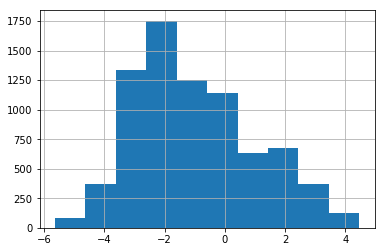

In [7]:
data_pilot_whiteetal['responsenorm'].hist()

The normalized variability scores (in being log-likelihoods) have a fairly heavy left skew.

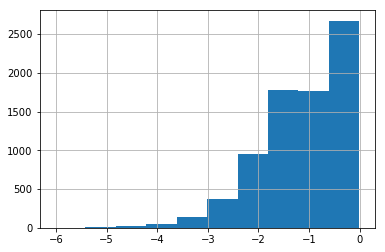

In [8]:
data_pilot_whiteetal['responselike'].hist()

The normalizer returns a column of normalized acceptabilities of the same length as the number of datapoints, though the values for each instance of a particular item are identical. To get only a single value for each item, we just average the scores.

In [9]:
data_pilot_whiteetal_mean = data_pilot_whiteetal.pivot_table(index=['frame', 'verb'], 
                                                             values=['responsenorm'])

data_pilot_whiteetal_mean.head()

responsenorm
frame          verb                 
It Ved NP WH S allow       -2.575900
               amaze        1.383899
               believe     -4.819947
               bother      -0.280093
               demand      -3.768812

In Section 3, we describe a simulation aimed at obtaining what we would expect in terms of agreement---measured by [rank (Spearman) correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)---in our replication. The following implements that simulation.

In [10]:
np.random.seed(55302)

def simulate_responses(normalized=data_pilot_whiteetal_mean, cuts=cuts_whiteetal):
    prob_leq = 1/(1+np.exp(normalized.values[:,0][None,:,None]-cuts[:,None,:]))
    
    unif_samps = np.random.uniform(0, 1, size=prob_leq.shape[:-1])
    cat_samps = np.sum(prob_leq < unif_samps[:,:,None], axis=2)
    
    return cat_samps
    
simulated = [simulate_responses() for _ in range(999)]

corr = [spearmanr(sim.T).correlation.flatten() for sim in simulated]
corr = [np.nan_to_num(r[r!=1]) for r in corr]
corr_means = [np.mean(r) for r in corr]

np.round(np.percentile(corr_means, [2.5, 50, 97.5]), 3)

array([ 0.511,  0.516,  0.521])

## Replication of White et al.

Our replication of White et al. is used to assess whether the bleaching method yields the same results as a more standard approach using contentful sentences. We release the replication data through the [MegaAttitude website](http://megaattitude.io). The raw data itself can be found [here](http://megaattitude.io/projects/mega-acceptability/mega-acceptability-replication-v1/mega-acceptability-replication-v1.tsv).

In [11]:
replication_url = 'http://megaattitude.io/projects/mega-acceptability/mega-acceptability-replication-v1/mega-acceptability-replication-v1.tsv'

data_pilot_replication = pd.read_csv(replication_url, sep='\t')

data_pilot_replication.head()

,participant,list,presentationorder,verb,frame,response,nativeenglish,sentence
0,31,0,1,want,NP Ved S,1,True,Someone wanted something happened.
1,31,0,2,doubt,NP Ved VPing,2,True,Someone doubted doing something.
2,31,0,3,think,NP Ved NP S,1,True,Someone thought someone something happened.
3,31,0,4,hear,It Ved NP to VP,1,True,It heard someone to do something.
4,31,0,5,want,NP Ved NP about NP,2,True,Someone wanted someone about something.


As before, we need to hash the response, item, and participant information for input to the normalizer.

In [12]:
data_pilot_replication['response'] = data_pilot_replication['response'].astype('int')
data_pilot_replication['verbframe'] = (data_pilot_replication['verb']+'-'+\
                                       data_pilot_replication['frame']).astype('category')
data_pilot_replication['participant'] = data_pilot_replication['participant'].astype('category')

data_pilot_replication.head()

,participant,list,presentationorder,verb,frame,response,nativeenglish,sentence,verbframe
0,31,0,1,want,NP Ved S,1,True,Someone wanted something happened.,want-NP Ved S
1,31,0,2,doubt,NP Ved VPing,2,True,Someone doubted doing something.,doubt-NP Ved VPing
2,31,0,3,think,NP Ved NP S,1,True,Someone thought someone something happened.,think-NP Ved NP S
3,31,0,4,hear,It Ved NP to VP,1,True,It heard someone to do something.,hear-It Ved NP to VP
4,31,0,5,want,NP Ved NP about NP,2,True,Someone wanted someone about something.,want-NP Ved NP about NP


The `cat.codes` attribute can then be used to hash the relevant column, before it is passed to the normalizer.

In [13]:
if 'whiteetal-replication.tsv' in os.listdir(os.path.join(os.getcwd(), 'data')):
    print('Reloading White et al. replication data with normalization from cache...')
    
    data_pilot_replication = pd.read_csv('data/whiteetal-replication.tsv', sep='\t')
    
else:
    with tf.Session() as sess:
        normed = fit_normalizer(data_pilot_replication.response-1,
                                data_pilot_replication.verbframe.cat.codes.values,
                                data_pilot_replication.participant.cat.codes,
                                seed=40392)
        
    data_pilot_replication['responsenorm'], data_pilot_replication['responselike'], _, _ = normed
    
    data_pilot_replication.to_csv('data/whiteetal-replication.tsv', index=False, sep='\t')

Reloading White et al. replication data with normalization from cache...


As for White et al.'s data, the normalized acceptability scores have a fairly heavy right skew.

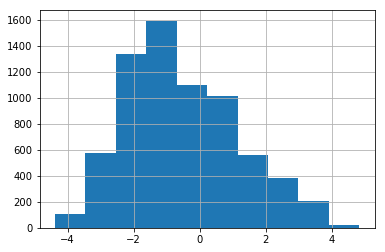

In [14]:
_ = data_pilot_replication['responsenorm'].hist()

Also as for White et al.'s data, the likelihood has a heavy left skew.

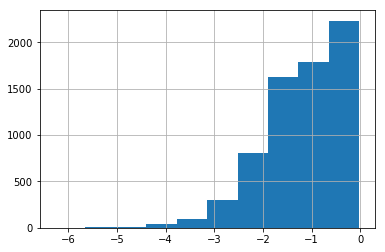

In [15]:
_ = data_pilot_replication['responselike'].hist()

To get only a single value for each item, we just average the scores.

In [16]:
data_pilot_replication_mean = data_pilot_replication.pivot_table(index=['frame', 'verb'], 
                                                                 values=['responsenorm'])

data_pilot_replication_mean.head()

responsenorm
frame          verb                 
It Ved NP WH S allow       -2.709310
               amaze        1.886646
               believe     -2.453627
               bother       0.790402
               demand      -2.206902

To compute interannotator agreement, for each list, we compute the rank (Spearman) correlation between the ratings given by each participant that rated the items in that list. 

In [17]:
def compute_correlation_by_list(df, itemcol='verbframe', listcol='list'):
    corrs_replication = []
    
    for l, df_sub in df.groupby(listcol):
        done = []
        for s1 in df_sub.participant.unique():
            for s2 in df_sub.participant.unique():
                if s1 != s2 and s2 not in done:
                    subj1 = df_sub[df_sub.participant==s1]
                    subj2 = df_sub[df_sub.participant==s2]
                    merged = pd.merge(subj1[[itemcol, 'response']], 
                                      subj2[[itemcol, 'response']], 
                                      on=itemcol)
                    r = spearmanr(merged.response_x, merged.response_y)[0]

                    corrs_replication.append([l, s1, s2, r])
                    corrs_replication.append([l, s2, s1, r])
                    
            done.append(s1)

    corrs_replication_df = pd.DataFrame(corrs_replication, 
                                        columns=[listcol, 'subject1', 'subject2', 'corr'])

    return corrs_replication_df

In [18]:
corrs_replication_df = compute_correlation_by_list(data_pilot_replication)

corrs_replication_df.head()

,list,subject1,subject2,corr
0,0,31,80,0.595288
1,0,80,31,0.595288
2,0,31,104,0.666080
3,0,104,31,0.666080
4,0,31,77,0.649100


We then estimate the overall agreement by averaging these correlations. We estimate 95% confidence intervals for this average correlation using a nonparametric bootstrap.

In [19]:
np.random.seed(302938)

corrs_replication_mean_boot = np.array([corrs_replication_df['corr'].sample(frac=1, replace=True).mean() 
                                        for _ in range(999)])

corrs_replication_mean_boot_stats = [corrs_replication_mean_boot.mean(), 
                                     np.percentile(corrs_replication_mean_boot, 2.5), 
                                     np.percentile(corrs_replication_mean_boot, 97.5)]

np.round(corrs_replication_mean_boot_stats, 3)

array([ 0.528,  0.509,  0.545])

### Replication comparison

In [20]:
data_pilot_whiteetal_cast = data_pilot_whiteetal.pivot_table(index='frame', 
                                                             columns='verb', 
                                                             values='responsenorm')

data_pilot_whiteetal_cast.head()

verb,allow,amaze,believe,bother,demand,deny,doubt,expect,feel,forbid,...,realize,remember,say,see,suppose,tell,think,understand,want,worry
frame,,,,,,,,,,,,,,,,,,,,,
It Ved NP WH S,-2.575900,1.383899,-4.819947,-0.280093,-3.768812,-3.834945,-2.925101,-3.855969,-3.113154,-3.821176,...,-2.888482,-3.106076,-4.598869,-3.004887,-3.631132,-0.041628,-3.161685,-2.470002,-2.530778,-0.058607
It Ved NP WH to VP,-3.541134,-1.054632,-3.096634,-1.893450,-4.652484,-2.376985,-2.697288,-4.838109,-3.582346,-1.748285,...,-4.057424,-3.479458,-3.362787,-2.985125,-3.573997,-0.102379,-3.469579,-3.491827,-3.135723,-0.819462
It Ved NP that S,-3.488551,1.394522,-3.285061,3.299719,-2.815064,-3.115567,-1.424750,-2.671996,-3.427563,-3.507108,...,-4.634511,-3.193518,-2.499019,-3.776903,-2.772027,0.356424,-2.612338,-2.617866,-2.348163,2.271333
It Ved NP to VP,1.151204,0.028057,-2.389529,1.460585,-2.577164,-3.234733,-2.385307,-1.457155,-3.681897,-0.853991,...,-2.821838,-2.796085,-3.870264,-1.972584,-3.405998,0.092320,-3.927061,-3.926939,-0.354464,-0.360239
NP Ved,-0.152676,-0.855724,3.447867,0.312293,-0.571524,-0.322697,0.645922,0.391123,-0.843591,1.460695,...,1.064980,3.246453,0.938927,0.770398,-0.343077,0.432836,0.641845,2.660394,-0.315050,2.987510


In [21]:
data_pilot_replication_cast = data_pilot_replication.pivot_table(index='frame', 
                                                                 columns='verb', 
                                                                 values='responsenorm')
data_pilot_replication_cast = data_pilot_replication_cast.loc[data_pilot_whiteetal_cast.index, 
                                                              data_pilot_whiteetal_cast.columns]

data_pilot_replication_cast

verb,allow,amaze,believe,bother,demand,deny,doubt,expect,feel,forbid,...,realize,remember,say,see,suppose,tell,think,understand,want,worry
frame,,,,,,,,,,,,,,,,,,,,,
It Ved NP WH S,-2.709310,1.886646,-2.453627,0.790402,-2.206902,-1.118181,-1.957052,-1.817451,-2.153527,-1.824422,...,-2.873371,-1.935740,-2.035997,-1.516635,-2.565166,1.611016,-2.369171,-1.462762,-3.089411,1.091464
It Ved NP WH to VP,-2.459460,-0.473231,-2.169343,-0.958305,-1.675660,-2.016820,-2.961760,-2.279505,-3.580677,-0.848787,...,-1.920971,-1.318667,-2.401340,-2.544195,-2.655338,1.173009,-2.841321,-3.780117,-2.858645,-1.022983
It Ved NP that S,-1.276712,2.053392,-0.637210,1.405445,-0.969434,-1.830307,-0.504760,-2.704266,-1.867239,-0.937057,...,-2.005180,-1.183506,-1.830307,-0.845427,-1.860288,1.215564,-2.680916,-1.406513,-4.382843,0.770127
It Ved NP to VP,2.237944,0.769441,-1.635419,2.654106,0.417817,1.077002,-2.148079,0.624500,-2.233668,0.136335,...,-1.841024,-1.617512,-1.611595,-0.961435,-0.744092,2.447112,-2.533795,-1.237465,0.549139,0.186285
NP Ved,1.085641,0.311293,2.053392,0.525113,0.960125,-0.202646,1.023097,0.094838,-1.040847,0.784576,...,0.540569,1.195272,0.208865,0.568577,0.837141,2.084322,1.752040,3.134473,0.871324,2.131122
NP Ved NP,1.855199,-1.173300,3.746976,3.134473,1.059612,1.757399,2.321308,3.840800,1.570966,0.851622,...,2.355925,4.152754,3.417436,3.165476,1.791327,0.804300,2.566116,1.958546,2.982490,-2.115291
NP Ved NP NP,-1.164312,-2.040350,-2.786455,-1.864044,-1.445564,1.487758,-2.830738,-1.488870,-3.219584,0.666958,...,-0.890890,-2.179151,-1.649819,-1.175060,-1.402308,3.113915,-0.903816,-1.876722,-2.471462,-2.218457
NP Ved NP S,-1.683433,-2.308503,-1.589542,-1.161719,-1.106185,-1.455201,-0.857372,-2.485486,-2.475269,-1.582680,...,-1.107261,-1.876722,-2.491290,-1.997820,-2.778465,0.811451,-3.070554,-2.108256,-0.690945,-1.727242
NP Ved NP VP,0.754529,-1.198640,-1.184191,-1.797903,1.665668,-0.111175,-0.186120,0.332354,-0.240550,0.856566,...,-1.611595,-0.815063,-0.696202,2.645066,0.005356,1.023097,-1.356591,-0.947800,-0.097016,-1.638795


In [22]:
np.diag(spearmanr(data_pilot_whiteetal_cast, data_pilot_replication_cast).correlation[:30,30:])

array([ 0.68898776,  0.60934372,  0.86607341,  0.85895439,  0.68498331,
        0.63426029,  0.78776418,  0.82780868,  0.7134594 ,  0.73259177,
        0.90300334,  0.9083426 ,  0.92258065,  0.77041157,  0.84026696,
        0.91101224,  0.78286986,  0.83479809,  0.72769744,  0.75737012,
        0.78509455,  0.87230256,  0.81446051,  0.832703  ,  0.72814238,
        0.6080089 ,  0.76996663,  0.82335929,  0.73348165,  0.85272525])

In [23]:
np.diag(spearmanr(data_pilot_whiteetal_cast.T, data_pilot_replication_cast.T).correlation[:30,30:])

array([ 0.26540601,  0.39532814,  0.41806653,  0.69922136,  0.73570634,
        0.24585605,  0.15506118,  0.40734149,  0.6298109 ,  0.82825362,
        0.43626251,  0.76596218,  0.70931138,  0.79399333,  0.85628476,
        0.80467186,  0.75528365,  0.7374861 ,  0.7592881 ,  0.5381535 ,
        0.77931034,  0.67430478,  0.74015573,  0.64404894,  0.63559511,
        0.85526755,  0.71301446,  0.77441602,  0.88431591,  0.59911012])

Figures 1 and 2 of the paper plot the correlation of judgments for each verb across frames and for each frame across verbs. To derive 95% confidence intervals, we compute a nonparametric boostrap. These (and all future plots) are saved to the `plots/` directory.

In [24]:
def bootstrap_correlation(df1, df2, nreplicates=999):

    ncols = df1.columns.shape[0]
    
    replicates = np.zeros([nreplicates, ncols, ncols])

    for i in range(nreplicates):
        indices = df1.sample(frac=1, replace=True).index

        replicates[i] = spearmanr(df1.loc[indices],
                                  df2.loc[indices])[0][:ncols,ncols:]
        
    aggfuncs = {'mean': lambda x: np.mean(x, axis=0),
                'loci': lambda x: np.percentile(x, 2.5, axis=0),
                'hici': lambda x: np.percentile(x, 97.5, axis=0)}

    replicates_stats = {}

    idx = list(df1.columns)
    cols = list(df2.columns)

    for name, f in aggfuncs.items():
        replicates_stats[name] = pd.DataFrame(f(replicates),
                                              index=idx,
                                              columns=cols).reset_index()

        replicates_stats[name] = pd.melt(replicates_stats[name], 
                                         id_vars='index', 
                                         var_name='df2_cols')

    corrs = pd.merge(replicates_stats['mean'],
                     pd.merge(replicates_stats['loci'],
                              replicates_stats['hici'],
                              on=['index', 'df2_cols']),
                     on=['index', 'df2_cols'])

    corrs = corrs.rename(columns={'index': 'df1_cols',
                                  'value': 'mean',
                                  'value_x': 'cilo',
                                  'value_y': 'cihi'})
    
    return corrs

In [25]:
replication_frames_corrs = bootstrap_correlation(data_pilot_whiteetal_cast.T, 
                                                 data_pilot_replication_cast.T)
    
replication_frames_corrs.head()

,df1_cols,df2_cols,mean,cilo,cihi
0,It Ved NP WH S,It Ved NP WH S,0.257002,-0.192635,0.644554
1,It Ved NP WH to VP,It Ved NP WH S,0.478120,0.105088,0.757039
2,It Ved NP that S,It Ved NP WH S,0.413417,0.021324,0.702687
3,It Ved NP to VP,It Ved NP WH S,0.310400,-0.095276,0.669039
4,NP Ved,It Ved NP WH S,-0.132533,-0.491774,0.260270


/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Conflicts with tidy packages ---------------------------------------------------

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: filter(): dplyr, stats
lag():    dplyr, stats

  warnings.warn(x, RRuntimeWarning)


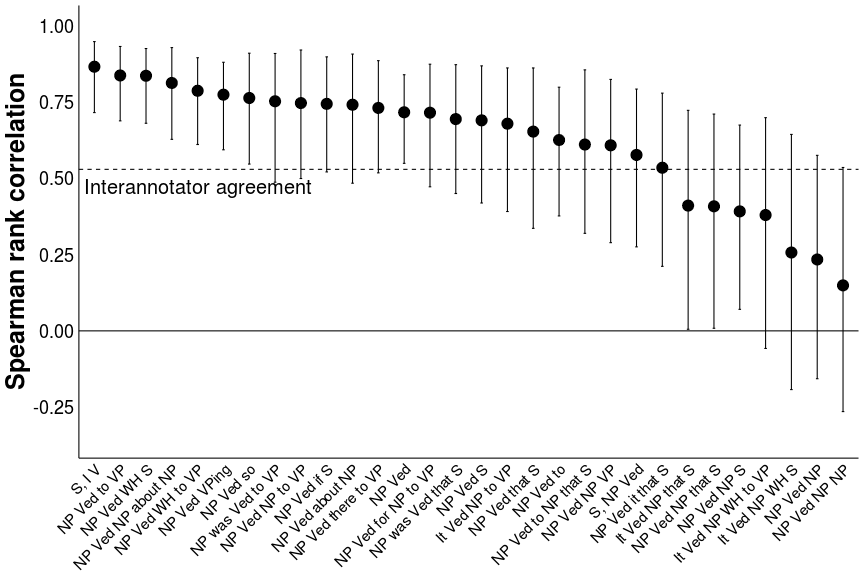

In [26]:
%%R -i replication_frames_corrs -w 12 -h 8 -u in

library(tidyverse)
library(forcats)

theme_set(theme_classic())

replication_frames_corrs_sub <- subset(replication_frames_corrs, df1_cols==df2_cols)

p <- ggplot(replication_frames_corrs_sub, 
            aes(x=fct_reorder(df1_cols, -mean), y=mean, ymin=cilo, ymax=cihi)) + 
geom_point(size=5) +
geom_errorbar(width=.1) +
geom_hline(yintercept=0) +
geom_hline(yintercept=0.53, linetype=2) +
annotate('text', label='Interannotator agreement', x=5, y=.45, size=7, vjust="left") +
scale_y_continuous(name='Spearman rank correlation', breaks=c(-.25, 0, .25, .5, .75, 1), limits=c(-.35, 1)) +
theme(axis.ticks=element_blank(), 
      axis.text.x=element_text(size=15, angle=45, hjust=1, color="black"),
      axis.title.x=element_blank(), 
      axis.text.y=element_text(size=18, color="black"), 
      axis.title.y=element_text(size=25, face="bold"))

ggsave('plots/replication_correlation_frame_point.pdf', width=12, height=8)

p

In [27]:
replication_verbs_corrs = bootstrap_correlation(data_pilot_whiteetal_cast, 
                                                 data_pilot_replication_cast)
    
replication_verbs_corrs.head()

,df1_cols,df2_cols,mean,cilo,cihi
0,allow,allow,0.671741,0.421597,0.842199
1,amaze,allow,0.057209,-0.295093,0.412398
2,believe,allow,0.344316,-0.015972,0.643523
3,bother,allow,0.218563,-0.148242,0.564052
4,demand,allow,0.581145,0.264487,0.803531


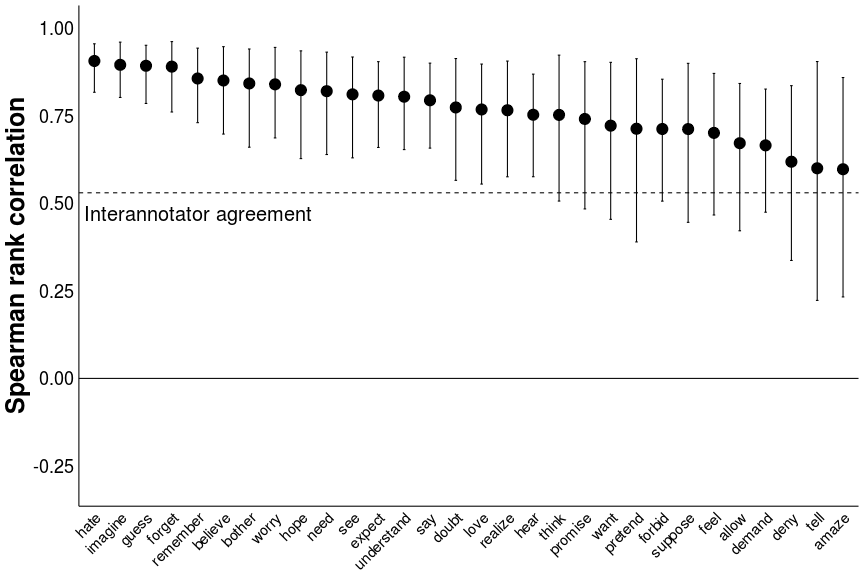

In [28]:
%%R -i replication_verbs_corrs -w 12 -h 8 -u in

replication_verbs_corrs_sub <- subset(replication_verbs_corrs, df1_cols==df2_cols)

p <- ggplot(replication_verbs_corrs_sub, 
            aes(x=fct_reorder(df1_cols, -mean), y=mean, ymin=cilo, ymax=cihi)) + 
geom_point(size=5) +
geom_errorbar(width=.1) +
geom_hline(yintercept=0) +
geom_hline(yintercept=0.53, linetype=2) +
annotate('text', label='Interannotator agreement', x=5, y=.45, size=7, vjust="left") +
scale_y_continuous(name='Spearman rank correlation', breaks=c(-.25, 0, .25, .5, .75, 1), limits=c(-.3, 1)) +
theme(axis.ticks=element_blank(), 
      axis.text.x=element_text(size=15, angle=45, hjust=1, color="black"),
      axis.title.x=element_blank(), 
      axis.text.y=element_text(size=18, color="black"), 
      axis.title.y=element_text(size=25, face="bold"))

ggsave('plots/replication_correlation_verb_point.pdf', width=12, height=8)

p

# The MegaAcceptability Dataset

Section 4 of the paper presents the [MegaAcceptability v1](http://megaattitude.io/projects/mega-acceptability/) dataset, which uses the bleaching method validated in Section 3. The dataset itself is available [here](http://megaattitude.io/projects/mega-acceptability/mega-acceptability-v1/mega-acceptability-v1.tsv).

In [29]:
data_url = 'http://megaattitude.io/projects/mega-acceptability/mega-acceptability-v1/mega-acceptability-v1.tsv'

data = pd.read_csv(data_url, sep='\t')

data.head()

,participant,list,presentationorder,verb,frame,response,nativeenglish,sentence
0,4,862,1,turn_out,NP was Ved whichNP to VP,2.0,True,Someone was turned out which thing to do.
1,381,862,1,turn_out,NP was Ved whichNP to VP,1.0,True,Someone was turned out which thing to do.
2,395,862,1,turn_out,NP was Ved whichNP to VP,2.0,True,Someone was turned out which thing to do.
3,621,862,1,turn_out,NP was Ved whichNP to VP,1.0,True,Someone was turned out which thing to do.
4,527,862,1,turn_out,NP was Ved whichNP to VP,1.0,True,Someone was turned out which thing to do.


This dataset has 1,000 verbs each slotted into 50 syntactic frames, and five judgments per pair were collected, yield 250,000 rows.

In [30]:
data.shape[0]

250000

A Mechanical Turk error yielded null values for 10 judgments.

In [31]:
data.response.isnull().sum()

10

We filter the rows corresponding to those judgments, yielding 249,990 rows of non-null data.

In [32]:
data = data[~data.response.isnull()]

data.shape[0]

249990

Additionally, four participants reported being non-native English speakers. These participants rated a total of 12 lists.

In [33]:
data[~data.nativeenglish].participant.unique().shape[0], data[~data.nativeenglish].list.unique().shape[0]

(4, 12)

These 12 lists correspond to 0.24% of the data.

In [34]:
data[~data.nativeenglish].list.unique().shape[0]*50/250000

0.0024

We remove the data provided by these participants.

In [35]:
data = data[data.nativeenglish]

The data only ships with the citation form of the verb and does not indicate which token(s) in the sentence correspond to the verb. Knowing this will be important later when deriving representations of verbs' frequency distributions, and so we extract it now.

In [36]:
def get_idx(sentence, template, verblemma):
    tokens = sentence.split()
    lemmasplit = verblemma.split('_')
    
    if template == 'S, I V':
        if len(lemmasplit) > 1:
            return [len(tokens)-3, len(tokens)-2]
        else:
            return [len(tokens)-2]
    else:  
        idx = np.where([w=='Ved' for w in template.split()])[0][0]
        
        if len(lemmasplit) > 1:
            return [idx, idx+1]
        else:
            return [idx]

def get_verb_form(sentence, idx):
    tokens = np.array(sentence.split())
    return ' '.join([c for t in tokens[idx] for c in t.split('_')])

data['sentence'] = data.sentence.str.replace('-', '')
data['sentence'] = data.sentence.str.replace('.', ' .')
data['sentence'] = data.sentence.str.replace(',', ' ,')
data['sentence'] = data.sentence.str.replace('_', ' ')

data['verbidx'] = data[['sentence', 'frame', 'verb']].apply(lambda x: get_idx(*x), axis=1)
data['verbform'] = data[['sentence', 'verbidx']].apply(lambda x: get_verb_form(*x), axis=1)

As for the validation experiments, we also need to hash items, participants, and responses for use by the normalizer. We do this by converting the corresponding columns to categorical variables.

In [37]:
data['response'] = data['response'].astype('int')
data['framevoice'] = data['frame'].astype('category')
data['verbframevoice'] = (data['verb'] + '-' +\
                          data['frame']).astype('category')
data['participant'] = data['participant'].astype('category')

data.head()

,participant,list,presentationorder,verb,frame,response,nativeenglish,sentence,verbidx,verbform,framevoice,verbframevoice
0,4,862,1,turn_out,NP was Ved whichNP to VP,2,True,Someone was turned out which thing to do .,"[2, 3]",turned out,NP was Ved whichNP to VP,turn_out-NP was Ved whichNP to VP
1,381,862,1,turn_out,NP was Ved whichNP to VP,1,True,Someone was turned out which thing to do .,"[2, 3]",turned out,NP was Ved whichNP to VP,turn_out-NP was Ved whichNP to VP
2,395,862,1,turn_out,NP was Ved whichNP to VP,2,True,Someone was turned out which thing to do .,"[2, 3]",turned out,NP was Ved whichNP to VP,turn_out-NP was Ved whichNP to VP
3,621,862,1,turn_out,NP was Ved whichNP to VP,1,True,Someone was turned out which thing to do .,"[2, 3]",turned out,NP was Ved whichNP to VP,turn_out-NP was Ved whichNP to VP
4,527,862,1,turn_out,NP was Ved whichNP to VP,1,True,Someone was turned out which thing to do .,"[2, 3]",turned out,NP was Ved whichNP to VP,turn_out-NP was Ved whichNP to VP


Figure 6 of the paper plots verbs' mean likert scale rating (viewed as though with were an interval score) in the `NP __ed that S` frame against the mean rating in the `NP __ed NP that S` frame.

In [38]:
verb_frame_raw = data.pivot_table(index='verb', columns='frame', values='response').reset_index()

verb_frame_raw.head()

frame,verb,NP Ved,NP Ved NP,NP Ved NP VP,NP Ved NP VPing,NP Ved NP that S,NP Ved NP that S[+future],NP Ved NP that S[-tense],NP Ved NP to NP,NP Ved NP to VP[+eventive],...,NP was Ved that S[+future],NP was Ved that S[-tense],NP was Ved to VP[+eventive],NP was Ved to VP[-eventive],NP was Ved whether S,NP was Ved whether S[+future],NP was Ved whether to VP,NP was Ved whichNP S,NP was Ved whichNP to VP,"S, I V"
0,abhor,3.6,4.75,1.4,3.8,1.6,1.4,1.2,2.6,3.2,...,4.0,4.4,4.2,2.0,1.8,3.6,2.2,3.0,2.4,2.6
1,absolve,1.8,4.20,2.2,2.6,2.4,1.2,2.2,2.2,2.8,...,2.8,2.2,1.8,2.2,2.2,2.4,1.6,1.2,1.2,2.4
2,accept,6.6,6.00,2.8,5.2,2.0,2.0,2.4,3.4,4.6,...,2.2,2.6,4.8,3.8,2.4,2.4,2.0,2.2,2.2,5.0
3,acclaim,4.4,4.60,1.2,4.4,1.4,2.0,1.2,5.2,2.0,...,1.4,1.4,2.2,5.6,3.0,1.4,1.8,2.8,1.0,2.2
4,accredit,2.2,3.60,1.2,2.8,1.2,4.2,2.0,6.6,1.4,...,1.4,2.6,2.8,3.8,2.6,2.8,3.0,1.2,1.6,2.6


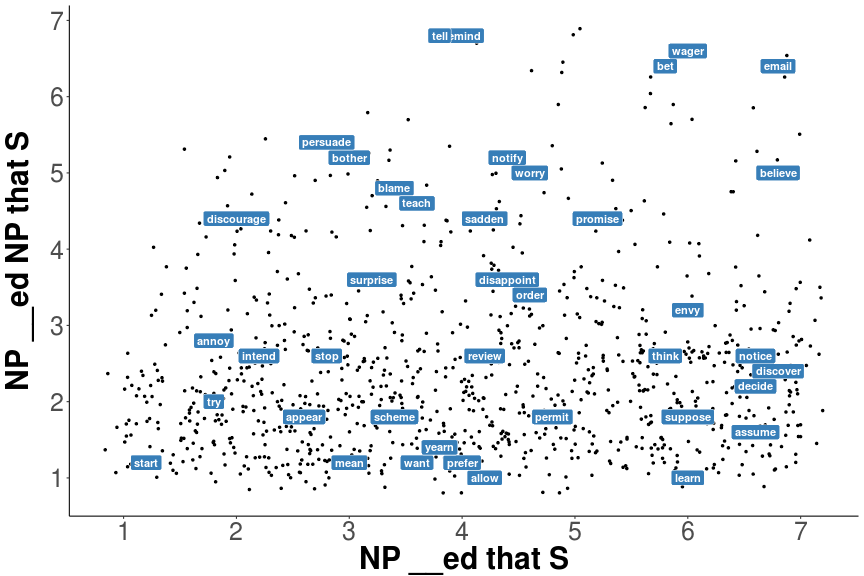

In [39]:
%%R -i verb_frame_raw -w 12 -h 8 -u in

verbs <- c('think', 'believe', 'tell', 'want', 'start', 'stop', 'annoy', 'bother', 
           'seem', 'appear', 'email', 'bet', 'notify', 'try', 'remind', 
           'wager', 'promise', 'suppose', 'assume', 'decide', 'worry', 
          'persuade', 'teach', 'blame', 'surprise', 'discourage', 'sadden',
          'disappoint', 'envy', 'order', 'mean', 'yearn', 'scheme', 'prefer', 
           'discover', 'notice', 'intend', 'review', 'learn', 'permit', 'allow')

p <- ggplot(verb_frame_raw, aes(x=NP.Ved.that.S, y=NP.Ved.NP.that.S)) + 
geom_point(size=1, position=position_jitter(0.2, 0.2)) +
geom_label(data=filter(verb_frame_raw, verb %in% verbs), 
                 aes(label=verb), 
                 fontface="bold", fill="#377eb8", color="white", alpha=1) +
scale_x_continuous(name='NP __ed that S', breaks=seq(1,7)) +
scale_y_continuous(name='NP __ed NP that S', breaks=seq(1,7)) +
theme(axis.text=element_text(size=25),
      axis.title=element_text(size=30, face="bold"),
      axis.title.y=element_text(margin = margin(t = 0, r = 20, b = 0, l = 0)),
     legend.position="none")

ggsave('plots/megaattitude_frame_sample_raw.pdf', width=12, height=8)

p

In Appendix C, we compute interannotator agreement for each pair of participants that rated the same list. The slightly lower agreement here, compared to the pilots, is one reason we weight the normalization by average annotator agreement.

In [40]:
corrs_bulk_df = compute_correlation_by_list(data, 'verbframevoice', 'list')

corrs_bulk_df.head()

/opt/conda/lib/python3.5/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.5/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,list,subject1,subject2,corr
0,0,12,378,0.453589
1,0,378,12,0.453589
2,0,12,101,0.499512
3,0,101,12,0.499512
4,0,12,256,0.512275


In [41]:
np.random.seed(40392)

corrs_bulk_mean_boot = np.array([corrs_bulk_df['corr'].sample(frac=1, replace=True).mean() 
                                        for _ in range(999)])
corrs_bulk_median_boot = np.array([corrs_bulk_df['corr'].sample(frac=1, replace=True).median() 
                                        for _ in range(999)])

np.round(np.percentile(corrs_bulk_median_boot, [2.5, 50, 97.5]), 3)

array([ 0.451,  0.455,  0.458])

The distribution of agreement scores is fairly heavily left skew. This suggests that most annotators are doing a reasonable job with a few drawing down the overall agreement.

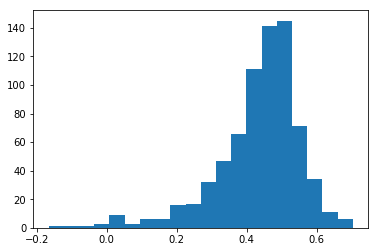

In [42]:
_ = plt.hist(corrs_bulk_df.pivot_table(index='subject1', values=['corr'])['corr'], bins=20)

To derive the participant quality score described in Appendix C, we first fitt a linear mixed effects model with random intercepts for participant and list to the Spearman rank correlations.

In [43]:
%%R -i corrs_bulk_df -o subj_qual

library(lme4)

m <- lmer(corr ~ 1 + (1|subject1) + (1|list), data=corrs_bulk_df)

subj_qual <- as.data.frame(ranef(m)$subject1)
subj_qual$subj <- row.names(subj_qual)
names(subj_qual) <- c('agreement', 'participant')

summary(m)

/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘Matrix’


  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:tidyr’:

    expand


  warnings.warn(x, RRuntimeWarning)


Linear mixed model fit by REML ['lmerMod']
Formula: corr ~ 1 + (1 | subject1) + (1 | list)
   Data: corrs_bulk_df

REML criterion at convergence: -13780.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1992 -0.5292  0.0947  0.6494  3.1976 

Random effects:
 Groups   Name        Variance Std.Dev.
 list     (Intercept) 0.009451 0.09722 
 subject1 (Intercept) 0.005436 0.07373 
 Residual             0.024926 0.15788 
Number of obs: 19872, groups:  list, 1000; subject1, 727

Fixed effects:
            Estimate Std. Error t value
(Intercept) 0.428780   0.004479   95.74


We then extract the Best Linear Unbiased Predictors for the participant intercepts; $z$-score these scores; and squash them to $[0, 1]$ using the normal cumulative distribution function (done in the cell that calls `fit_normalizer`).

In [44]:
subj_qual['agreement_norm'] = subj_qual['agreement']/subj_qual['agreement'].std()
subj_qual['participant'] = subj_qual['participant'].astype(int).astype('category')

data = pd.merge(data, subj_qual, on='participant')

To normalize the data, we use the same function as for the pilots, except we include our participant quality scores as weights.

In [45]:
if 'mega-attitude-v1.tsv' in os.listdir(os.path.join(os.getcwd(), 'data')):
    print('Reloading data with normalization from cache...')
    data = pd.read_csv('data/mega-attitude-v1.tsv', sep='\t')

else:
    with tf.Session() as sess:
        normed = fit_normalizer(data.response-1,
                                data.verbframevoice.astype('category').cat.codes.values,
                                data.participant.astype('category').cat.codes,
                                weights=sp.stats.norm.cdf(data.agreement_norm.values),
                                seed=10239)

    data['responsenorm'], data['responselike'], jumps, cuts = normed
    
    data.to_csv('data/mega-attitude-v1.tsv', index=False, sep='\t')

Reloading data with normalization from cache...


We place these normalized values in a dataframe, wherein each row corresponds to a verb-frame pair. This will be written out to `data/mega-attitude-v1-normalized.tsv` at the end of this notebook (after judgments for some additional verbs are collected).

In [46]:
normalized = data.pivot_table(index=['verb', 'frame'], values='responsenorm').reset_index()
weightedvar = data.groupby(['verb', 'frame'])[['responselike', 'agreement_norm']].apply(lambda x: x.responselike.sum()/sp.stats.norm.cdf(x.agreement_norm).sum()).reset_index().rename(columns={0: 'responsevar'})

normalized = pd.merge(normalized, weightedvar)

normalized = pd.merge(normalized, data[['verb', 'verbform', 'frame', 'sentence']].drop_duplicates())
normalized = normalized[['verb', 'verbform', 'frame', 'sentence', 'responsenorm', 'responsevar']]

normalized.head()

,verb,verbform,frame,sentence,responsenorm,responsevar
0,abhor,abhorred,NP Ved,Someone abhorred .,0.937020,-2.288458
1,abhor,abhorred,NP Ved NP,Someone abhorred something .,1.757018,-1.554375
2,abhor,abhorred,NP Ved NP VP,Someone abhorred someone do something .,-1.728826,-1.018119
3,abhor,abhorred,NP Ved NP VPing,Someone abhorred someone doing something .,1.018668,-1.245996
4,abhor,abhorred,NP Ved NP that S,Someone abhorred someone that something happen...,-0.595499,-0.585704


To plot some of these normalized ratings, we first cast both the normalized ratings...

In [47]:
acceptability = normalized.pivot_table(index='verb', columns='frame', values='responsenorm')

acceptability.head()

frame,NP Ved,NP Ved NP,NP Ved NP VP,NP Ved NP VPing,NP Ved NP that S,NP Ved NP that S[+future],NP Ved NP that S[-tense],NP Ved NP to NP,NP Ved NP to VP[+eventive],NP Ved NP to VP[-eventive],...,NP was Ved that S[+future],NP was Ved that S[-tense],NP was Ved to VP[+eventive],NP was Ved to VP[-eventive],NP was Ved whether S,NP was Ved whether S[+future],NP was Ved whether to VP,NP was Ved whichNP S,NP was Ved whichNP to VP,"S, I V"
verb,,,,,,,,,,,,,,,,,,,,,
abhor,0.937020,1.757018,-1.728826,1.018668,-0.595499,-1.710499,-1.373725,-0.151609,-0.970789,-0.575904,...,0.164902,0.284888,0.482186,0.197919,-0.195694,0.337812,0.177505,0.362723,-0.967037,0.135286
absolve,-0.663034,1.145783,-0.666244,-0.186460,-0.113224,-1.373725,-0.096106,-0.640620,-0.300382,-0.155661,...,-0.036710,-0.172364,-0.325584,-0.754879,0.214287,-0.175035,-0.354602,-0.802287,-0.942693,-0.574568
accept,3.408551,2.302293,-0.177098,2.355586,-1.155363,-1.335952,-0.889221,-0.434964,0.722037,0.292264,...,-0.229893,-0.342262,0.718703,0.448758,-0.278486,-0.917158,-0.041599,-0.371269,-0.221968,1.196415
acclaim,0.787558,1.534969,-1.524099,0.749058,-1.574656,-0.819817,-1.679829,1.100519,-0.715073,-0.767939,...,-0.649803,-0.836003,-0.044266,0.803186,-0.600169,-1.289758,-0.567637,-0.471043,-1.909964,-0.218731
accredit,-0.146072,1.021509,-0.688883,0.177532,-1.242959,0.572064,-1.255702,2.689353,-1.051199,0.737418,...,-0.691179,-0.777956,0.756213,0.934650,-0.211424,-0.628762,-0.363196,-0.981960,-1.089276,-0.087709


...and the variability scores.

In [48]:
variability = normalized.pivot_table(index='verb', columns='frame', values='responsevar')

variability.head()

frame,NP Ved,NP Ved NP,NP Ved NP VP,NP Ved NP VPing,NP Ved NP that S,NP Ved NP that S[+future],NP Ved NP that S[-tense],NP Ved NP to NP,NP Ved NP to VP[+eventive],NP Ved NP to VP[-eventive],...,NP was Ved that S[+future],NP was Ved that S[-tense],NP was Ved to VP[+eventive],NP was Ved to VP[-eventive],NP was Ved whether S,NP was Ved whether S[+future],NP was Ved whether to VP,NP was Ved whichNP S,NP was Ved whichNP to VP,"S, I V"
verb,,,,,,,,,,,,,,,,,,,,,
abhor,-2.288458,-1.554375,-1.018119,-1.245996,-0.585704,-0.428226,-0.287672,-1.556504,-1.191402,-1.228833,...,-1.585168,-1.288684,-1.720089,-1.370050,-0.924303,-2.080154,-1.539528,-1.648586,-1.038745,-1.673631
absolve,-0.838405,-1.146006,-1.097774,-1.021328,-0.999456,-0.287672,-1.235742,-1.308024,-1.159180,-1.679299,...,-1.779135,-1.152617,-1.007064,-1.210936,-1.796126,-1.360788,-1.148751,-1.438479,-0.549605,-2.091462
accept,-0.751094,-0.517740,-1.624442,-1.111979,-1.046828,-1.171281,-0.473013,-1.423625,-1.645666,-1.572007,...,-1.237238,-1.612939,-1.021392,-1.944890,-1.438450,-1.036512,-1.866513,-0.947385,-1.049784,-1.659088
acclaim,-2.598923,-1.410221,-0.503914,-1.527062,-0.622958,-0.718488,-0.457963,-1.852840,-0.816404,-0.940697,...,-0.576988,-1.147787,-0.673717,-1.210959,-1.108656,-0.632393,-1.483451,-0.904637,-0.353612,-1.264006
accredit,-1.589862,-1.253899,-0.505031,-1.923162,-0.238833,-2.073040,-0.651916,-0.784388,-0.564056,-1.777570,...,-0.663595,-1.532246,-1.807918,-2.086304,-1.136887,-1.172589,-1.272432,-0.438423,-1.109241,-1.349293


We will look at the same two frames we looked at for the mean ordinal scale ratings.

In [49]:
thatNPthat = pd.merge(acceptability[['NP Ved that S', 'NP Ved NP that S']],
                       variability[['NP Ved that S', 'NP Ved NP that S']],
                       left_index=True, right_index=True).reset_index()

thatNPthat.head()

frame,verb,NP Ved that S_x,NP Ved NP that S_x,NP Ved that S_y,NP Ved NP that S_y
0,abhor,1.130769,-0.595499,-1.875849,-0.585704
1,absolve,0.045888,-0.113224,-1.506999,-0.999456
2,accept,1.799351,-1.155363,-1.229153,-1.046828
3,acclaim,0.814327,-1.574656,-1.420315,-0.622958
4,accredit,-1.081249,-1.242959,-1.101848,-0.238833


Figure 7 plots these results.

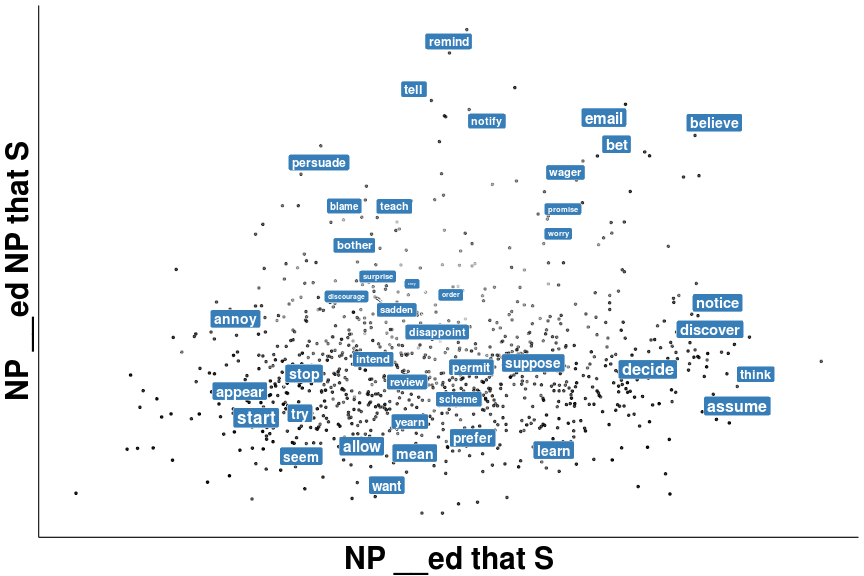

In [50]:
%%R -i thatNPthat -w 12 -h 8 -u in

library(ggrepel)

verbs <- c('think', 'believe', 'tell', 'want', 'start', 'stop', 'annoy', 'bother', 
           'seem', 'appear', 'email', 'bet', 'notify', 'try', 'remind', 
           'wager', 'promise', 'suppose', 'assume', 'decide', 'worry', 
          'persuade', 'teach', 'blame', 'surprise', 'discourage', 'sadden',
          'disappoint', 'envy', 'order', 'mean', 'yearn', 'scheme', 'prefer', 
           'discover', 'notice', 'intend', 'review', 'learn', 'permit', 'allow')

p <- ggplot(thatNPthat, aes(x=NP.Ved.that.S_x, y=NP.Ved.NP.that.S_x, 
                       size=NP.Ved.that.S_y+NP.Ved.NP.that.S_y,
                      alpha=NP.Ved.that.S_y+NP.Ved.NP.that.S_y)) + 
geom_point(size=1) +
geom_label_repel(data=filter(thatNPthat, verb %in% verbs), 
                 aes(label=verb), 
                 fontface="bold", fill="#377eb8", color="white", alpha=1) +
scale_x_continuous(name='NP __ed that S') +
scale_y_continuous(name='NP __ed NP that S') +
theme(axis.ticks=element_blank(), 
      axis.text=element_blank(),
      axis.title=element_text(size=30, face="bold"),
     legend.position="none")

ggsave('plots/megaattitude_frame_sample.pdf', width=12, height=8)

p

## Reliability

Finally, to estimate reliability we take the mean of the above-defined variability scores for each frame.

In [51]:
np.random.seed(30298)

boot = lambda x: np.percentile([np.mean(np.random.choice(np.exp(x), size=len(x), replace=True)) 
                                for _ in range(999)], [2.5, 50, 97.5])

var_stats = normalized.groupby('frame').responsevar.apply(boot).reset_index()

var_stats['med'] = var_stats['responsevar'].map(lambda x: x[1])
var_stats['cilo'] = var_stats['responsevar'].map(lambda x: x[0])
var_stats['cihi'] = var_stats['responsevar'].map(lambda x: x[2])

var_stats = var_stats.drop('responsevar', axis=1)

var_stats

,frame,med,cilo,cihi
0,NP Ved,0.308868,0.298711,0.318382
1,NP Ved NP,0.367946,0.356216,0.378430
2,NP Ved NP VP,0.334993,0.323948,0.346070
3,NP Ved NP VPing,0.306892,0.297901,0.317246
4,NP Ved NP that S,0.416769,0.405296,0.427781
5,NP Ved NP that S[+future],0.408211,0.396998,0.418944
6,NP Ved NP that S[-tense],0.432537,0.421683,0.443797
7,NP Ved NP to NP,0.327474,0.317158,0.337450
8,NP Ved NP to VP[+eventive],0.334780,0.324662,0.345323
9,NP Ved NP to VP[-eventive],0.329011,0.317590,0.339436


Figure 8 plots these results.

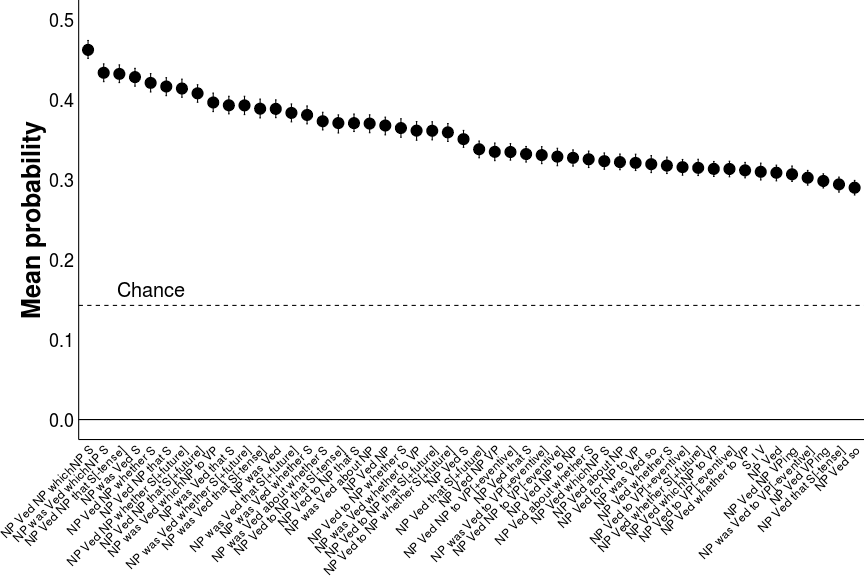

In [52]:
%%R -i var_stats -w 12 -h 8 -u in

p <- ggplot(var_stats, aes(x=fct_reorder(frame, -med), y=med, ymin=cilo, ymax=cihi)) + 
geom_point(size=5) +
geom_errorbar(width=.1) +
geom_hline(yintercept=0) +
geom_hline(yintercept=1/7, linetype=2) +
annotate('text', label='Chance', x=5, y=1/7+0.01, size=7, vjust="left") +
scale_y_continuous(name='Mean probability', 
                   breaks=seq(0, 0.5, .1), limits=c(0, .5)) +
theme(axis.ticks=element_blank(), 
      axis.text.x=element_text(size=12, angle=45, hjust=1, color="black"),
      axis.title.x=element_blank(), 
      axis.text.y=element_text(size=18, color="black"), 
      axis.title.y=element_text(size=25, face="bold"),
      plot.margin = margin(0, 0, 0, 0.75, "cm"))

ggsave('plots/megaattitude_frame_variability.pdf', width=12, height=8)

p

## Comparison to Other Normalization Methods

A reviewer requested that we show how other methods of aggregating the ratings for each item relate to the ordinal model-based normalization method employed for our validation experiments. This analysis is presented in Appendix C of the paper.

In [53]:
data['zscore'] = data.groupby('participant')['response'].transform(lambda x: (x - x.mean())/x.std())

We first compute the average response under each normalization method.

In [54]:
data_mean = data.pivot_table(index=['verb', 'frame'], values=['response', 'responsenorm', 'zscore']).reset_index()

data_mean.head()

,verb,frame,response,responsenorm,zscore
0,abhor,NP Ved,3.60,0.937020,0.256592
1,abhor,NP Ved NP,4.75,1.757018,0.808458
2,abhor,NP Ved NP VP,1.40,-1.728826,-0.861527
3,abhor,NP Ved NP VPing,3.80,1.018668,0.367291
4,abhor,NP Ved NP that S,1.60,-0.595499,-0.594956


And then we compute the correlations.

In [55]:
data_mean[['response', 'responsenorm', 'zscore']].corr()

,response,responsenorm,zscore
response,1.000000,0.923028,0.963681
responsenorm,0.923028,1.000000,0.946576
zscore,0.963681,0.946576,1.000000


Figure 15 in Appendix C plots the comparison.

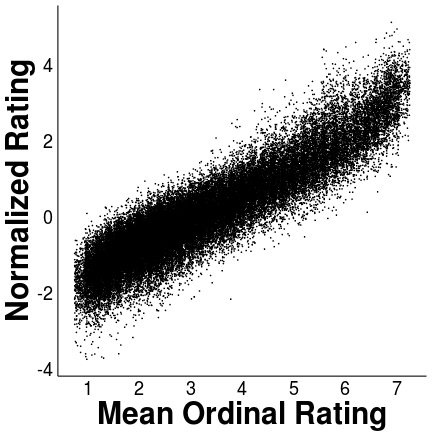

In [56]:
%%R -i data_mean -w 6 -h 6 -u in

p <- ggplot(data_mean, aes(x=response, y=responsenorm)) +
geom_point(size=0.05, position=position_jitter(0.25,0.25)) +
ylab('Normalized Rating') +
scale_x_continuous(name='Mean Ordinal Rating', breaks=seq(1,7)) +
theme(axis.ticks=element_blank(), 
      #axis.text=element_blank(),
      axis.title=element_text(size=30, face="bold"), 
      axis.text=element_text(size=18, color="black"))

ggsave('plots/rawmean_normalized.pdf', width=6, height=6)

p

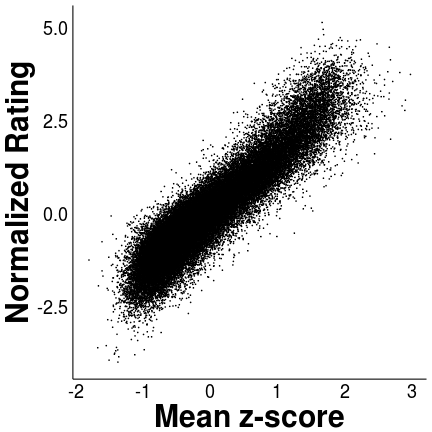

In [57]:
%%R -i data_mean -w 6 -h 6 -u in

p <- ggplot(data_mean, aes(x=zscore, y=responsenorm)) +
geom_point(size=0.05, position=position_jitter(0.25,0.25)) +
xlab('Mean z-score') +
ylab('Normalized Rating') +
theme(axis.ticks=element_blank(), 
      #axis.text=element_blank(),
      axis.title=element_text(size=30, face="bold"), 
      axis.text=element_text(size=18, color="black"))

ggsave('plots/zscore_normalized.pdf', width=6, height=6)

p

Figure 16 in Appendix C plots the marginal distribution for each.

/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘reshape2’


  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:tidyr’:

    smiths


  warnings.warn(x, RRuntimeWarning)


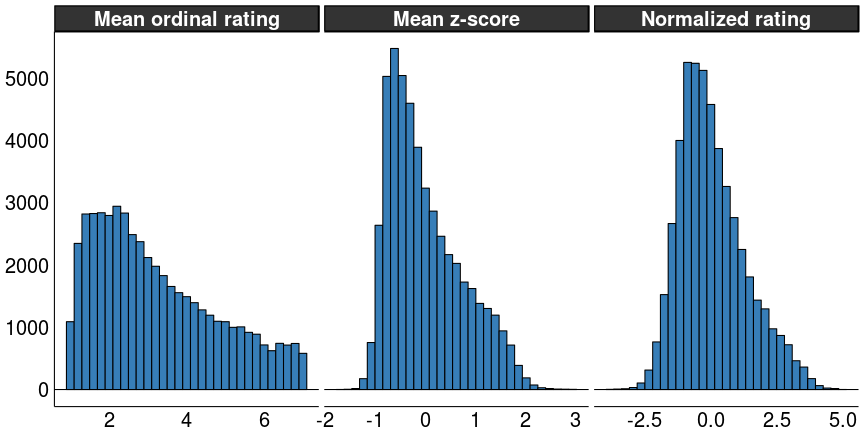

In [58]:
%%R -i data_mean -w 12 -h 6 -u in

library(reshape2)

data_mean_melt <- melt(data_mean, id.vars=c('verb', 'frame'))

data_mean_melt$variable <- as.factor(data_mean_melt$variable)
levels(data_mean_melt$variable) <- c('Mean ordinal rating', 'Normalized rating', 'Mean z-score')
data_mean_melt$variable <- ordered(data_mean_melt$variable, 
                                   levels=c('Mean ordinal rating', 'Mean z-score', 'Normalized rating'))

theme_set(theme_classic())

p <- ggplot(data_mean_melt, aes(x=value)) +
geom_histogram(bins=31, color="black", fill="#377eb8") +
geom_hline(yintercept=0) +
scale_y_continuous(breaks=seq(0, 5000, 1000)) +
facet_grid(~variable, scales="free_x") +
theme(axis.ticks=element_blank(), 
      #axis.text=element_blank(),
      axis.title=element_blank(),
      strip.background=element_rect(fill="#333333"),
      strip.text=element_text(color="white", size=20, face="bold"),
      axis.text=element_text(size=20, color="black"))

ggsave('plots/normalization_histograms.pdf', width=12, height=6)

p

# Relating Frequency and Acceptability

Section 5 of the paper presents an investigation of the extent to which a verb's subcategorization behavior can be predicted directly from the frequency with which it occurs in different syntactic structures in text. We use [VALEX](https://ilexir.co.uk/valex/index.html) to measure verb-frame cooccurrence. The file is available [here](https://s3-eu-west-1.amazonaws.com/ilexir-website-media/valex.tar).

To load VALEX, we'll first download the VALEX tar, then extract the files for each verb in the `lex-lrec-raw` lexicon files.

In [59]:
valex_dir = 'valex/lexicons/lex-lrec-raw/'

if 'valex' not in os.listdir(os.getcwd()):
    valex_url = 'https://s3-eu-west-1.amazonaws.com/ilexir-website-media/valex.tar'
    valex_raw = requests.get(valex_url).content

    with tarfile.open(fileobj=io.BytesIO(valex_raw)) as f:
        fpaths = {fp.split('/')[-1].split('.')[0]: fp for fp in f.getnames() if valex_dir in fp}
        f.extractall(members=[f.getmember(fp) for fp in fpaths.values()])
        
else:
    fpaths = {fn.split('.')[0]: os.path.join(valex_dir, fn) 
              for fn in os.listdir(valex_dir)}

Next, we'll run through each file, which we'll open using the `bz2.BZ2File` class, and we'll grep out both the subcat frame and the count of that subcat frame for each verb. (A very small subset of the files have some weird encoding issues that cause the iteration through the `bz2.BZ2File` object to never terminate, which is why we need the timeout.)

In [60]:
@timeout_decorator.timeout(10)
def extract_subcat_counts(fpath):
    with bz2.BZ2File(fpath) as f:
        fstr = f.read().decode('iso-8859-1')
        
        frames = re.findall(':SUBCAT (\(.+?\))', fstr)
        classes = re.findall(':CLASSES \(([0-9]+?) [0-9]+\)', fstr)
        counts = [int(c) for c in re.findall(':FREQCNT (\d+)', fstr)]
        
        assert len(frames)==len(classes)
        assert len(classes)==len(counts)
        
        return zip(frames, classes, counts)

if 'verbframe_counts.tsv' in os.listdir(os.path.join(os.getcwd(), 'data')):
    print('Loading VALEX counts from cache...')
    verbframe_counts_df = pd.read_csv('data/verbframe_counts.tsv', sep='\t')

else:
    verbframe_counts = []

    for v, fp in fpaths.items():
        try:
            for fc in extract_subcat_counts(fp):
                verbframe_counts.append([v]+list(fc))
        except timeout_decorator.TimeoutError:
            print('Error: file for "'+v+'" took too long to process')
        except OSError:
            print('Error: file for "'+v+'" has invalid data stream')

    verbframe_counts_df = pd.DataFrame(verbframe_counts, columns=['verb', 'frame', 'cls', 'framecount'])
    
    verbframe_counts_df.to_csv('data/verbframe_counts.tsv', index=False, sep='\t')
    
verbframe_counts_df.head()

Loading VALEX counts from cache...


,verb,frame,cls,framecount
0,gripe,(VSUBCAT NONE),22,434
1,gripe,(VSUBCAT PP),87,252
2,gripe,(VSUBCAT SCOMP),104,150
3,gripe,(VSUBCAT SCOMP),106,75
4,gripe,(VSUBCAT SCOMP),26,51


We can plot these counts to get sense for what their distribution is.

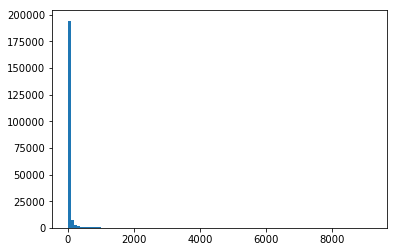

In [61]:
_ = plt.hist(verbframe_counts_df.framecount, bins=100)

These counts are roughly Zipf-Mandelbrot distributed.

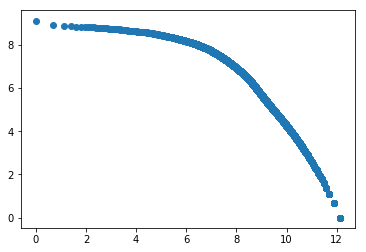

In [62]:
_ = plt.scatter(np.log(verbframe_counts_df.framecount.rank(ascending=False).values), 
                np.log(verbframe_counts_df.framecount))

We treat the subcat frame as the concatenation of the string identifier and the numeric identifier from Briscoe 2000 (see [Korhonen et al. 2006](https://www.aclweb.org/anthology/L06-1337/) for details).

In [63]:
verbframe_counts_df['scf'] = verbframe_counts_df.frame + '-' + verbframe_counts_df.cls.astype(str)

Next, we'll put the counts in the same form as the acceptabilities: verb-by-frame.

In [64]:
verbframe_counts_cast = verbframe_counts_df.pivot_table(index='verb', 
                                                        columns='scf', 
                                                        values='framecount', 
                                                        fill_value=0, 
                                                        aggfunc=np.sum)

verbframe_counts_cast.head()

scf,(VSUBCAT AP)-1,(VSUBCAT NONE)-129,(VSUBCAT NONE)-154,(VSUBCAT NONE)-22,(VSUBCAT NONE)-23,(VSUBCAT NP PRT +)-76,(VSUBCAT NP)-116,(VSUBCAT NP)-123,(VSUBCAT NP)-24,(VSUBCAT NP)-7,...,(VSUBCAT SING_PP)-85,(VSUBCAT VPBSE)-142,(VSUBCAT VPINF)-111,(VSUBCAT VPINF)-112,(VSUBCAT VPINF)-9,(VSUBCAT VPING)-19,(VSUBCAT VPING_PP)-86,(VSUBCAT VPPRT)-2,(VSUBCAT WHPP)-80,(VSUBCAT WHPP)-82
verb,,,,,,,,,,,,,,,,,,,,,
abandon,12,27,5,0,16,0,9,4,5883,167,...,2,0,0,1,0,6,6,1,0,0
abase,0,0,0,5,0,0,0,0,14,0,...,0,0,0,0,0,0,0,0,0,0
abash,2,13,3,78,4,0,0,0,55,1,...,0,0,0,2,0,0,0,0,0,0
abate,10,33,11,1514,53,3,0,0,0,6,...,0,0,0,4,0,3,0,1,0,0
abbreviate,1,1,1,27,2,0,0,0,69,2,...,0,0,0,1,0,0,0,0,0,0


The result is cooccurrence counts for 6,393 verbs in 109 frames.

In [65]:
verbframe_counts_cast.shape

(6393, 109)

Prior to using these counts, we need to normalize them. We describe four ways of doing this in the paper: a _Dirichlet-Categorical nomalizer_, a _Beta-Negative Binomial nomalizer_, _Pointwise Mutual Information_, and _Dunning's G_. 

## Normalizers

### Dirichlet-Categorical Normalizer

The Dirichlet-Categorical nomalizer aims to maximize for $\Theta$ in:

$$\mathbb{P}(\theta_v\;|\;\mathbf{c}_v; \alpha) \propto \mathbb{P}(\theta_v; \alpha)\prod_{f} \mathbb{P}(f\;|\;\theta_v)^{c_{vf}}$$

This just involves dividing each row by its sum, after adding a pseudocount to each cooccurrence count.

In [66]:
if 'dircat_normalized.pkl' in os.listdir(os.path.join(os.getcwd(), 'data')):
    print('Loading dircat_normalized from cache...')
    
    with open('data/dircat_normalized.pkl', 'rb') as f:
        dircat_normalized = pickle.load(f)

else:
    dircat_normalized = {s: verbframe_counts_cast.apply(lambda x: (x+s)/np.sum(x+s), axis=1)
                         for s in [0., 0.1, 0.2, 0.5, 1., 2., 5., 10., 20., 50.]}
    
    with open('data/dircat_normalized.pkl', 'wb') as f:
        pickle.dump(dircat_normalized, f)

Loading dircat_normalized from cache...


This gives us a maximum a posteriori estimate for the probability of seeing a particular frame under a Dirichlet prior with the pseudocount minus 1.

### Beta-Negative Binomial Normalizer

The Beta-Negative Binomial normalizer attempts to get something similar to an acceptability on the unit interval, where 1 is acceptable and 0 is unacceptable. We operationalize this as:

$$(\hat{\pi}_{vf}, \hat{r}_v) = \arg_{\pi_{vf}, r_v}\max \mathbb{P}(\pi_{vf}, r_v\;|\;c_v; \beta_1, \beta_2)$$

In [67]:
def negbin_normalizer(X, sparsity=1., tolerance=1e-6, maxiter=30000, verbose=1000, seed=30294):
    """Fit a beta-negative binomial normalizer
    
    Parameters
    ----------
    X : numpy.array[int]
        The counts (object x feature)
    sparsity : float
        The beta prior sparsity parameter
        sparsity = beta0 + 1 = beta1 + 1
    tolerance : float
        The amount of change in loss under which to stop
    maxiter : int
        The maximum number of iterations
    verbose : int
        How often to print the loss
    seed : int
        The random seed
    
    Returns
    -------
    rpos : numpy.array(float)
    Punit : numpy.array(float)
    """
    n_datapoints, n_obsfeats_X = X.shape
    
    # wrap our data in a tensorflow constant
    Xtf = tf.constant(X, dtype=tf.float32)
    
    rinit = tf.truncated_normal((n_datapoints,1), seed=seed)
    Pinit = tf.sigmoid(tf.truncated_normal(X.shape, seed=seed+1))
    
    r = tf.Variable(rinit)
    P = tf.Variable(Pinit)
    
    rpos = tf.square(r)
    Punit = tf.sigmoid(P)

    # define the sparsity prior
    logprior = sparsity*tf.log(Punit+1e-10) + sparsity*tf.log(1-Punit+1e-10)
    
    # define the link function
    lognormalizer = tf.lgamma(Xtf+rpos) - tf.lgamma(Xtf+1.) - tf.lgamma(rpos)
    loglike = lognormalizer + rpos*tf.log(1.-Punit)+Xtf*tf.log(Punit)

    # define the cross entropy (Bernoulli) loss
    loss = -tf.reduce_sum(loglike)-tf.reduce_sum(logprior) 
    
    # define the optimizer
    train_step = tf.train.AdamOptimizer().minimize(loss)
    
    # initialize the variables
    sess.run(tf.global_variables_initializer())
    
    # initialize a variable that will track the loss over iterations
    curr_loss = np.inf
    
    print()
    print('Fitting beta-negative binomial normalizer with sparsity =', sparsity)
    print()
    
    for i in range(maxiter):
        train_step.run()
        
        prev_loss = curr_loss
        curr_loss = loss.eval()
        
        finished = (prev_loss - curr_loss) < tolerance
        
        if verbose:
            if not (i % verbose) or finished:
                l = loss.eval()
                print('loss:\t', ' '*int(l >= 0), l)
                
        if finished:
            print()
            break
            
    return rpos.eval(), Punit.eval()

In [68]:
if 'negbin_normalized.pkl' in os.listdir(os.path.join(os.getcwd(), 'data')):
    print('Loading negbin_normalized from cache...')
    
    with open('data/negbin_normalized.pkl', 'rb') as f:
        negbin_normalized = pickle.load(f)

else:
    with tf.Session() as sess:
        negbin_models = {s: negbin_normalizer(verbframe_counts_cast.values, sparsity=s, seed=502938)
                         for s in [0., 0.1, 0.2, 0.5, 1., 2., 5., 10., 20., 50.]}
        
    negbin_normalized = {s: pd.DataFrame(np.concatenate([P, r], axis=1), 
                                     index=verbframe_counts_cast.index,
                                     columns=list(verbframe_counts_cast.columns)+['strength'])
                         for s, (r, P) in negbin_models.items()}
    
    with open('data/negbin_normalized.pkl', 'wb') as f:
        pickle.dump(negbin_normalized, f)

Loading negbin_normalized from cache...


### Pointwise Mutual Information

The pointwise mustual information is computed as:

$$\text{PMI}(v, f) = \log\frac{\mathbb{P}(v, f)}{\mathbb{P}(v)\cdot\mathbb{P}(f)}$$

To compute this quantity, we assume the Dirichlet-Categorical model described above and obtain MAP estimates for the parameters of the joint distribution $\mathbb{P}(v, f)$. The parameters of the marginal distributions $\mathbb{P}(v)$ and $\mathbb{P}(f)$ can then be obtained from the joint. We estimate these distributions using the same definition of the smoothing parameter $\lambda$.

In [69]:
def compute_pmi(mat, smoothing):
    """Compute the PMI
    
    Parameters
    ----------
    mat : pandas.DataFrame
        A matrix of counts
    smoothing : float
        A pseudocount used for smoothing
        
    Returns
    -------
    pmi : pandas.DataFrame
    """
    mat_smoothed = mat.values+smoothing
    total_count = mat_smoothed.sum()
    log_total_count = np.log(total_count)
    
    marginal_verb = mat_smoothed.sum(axis=1)
    marginal_frame = mat_smoothed.sum(axis=0)
    
    pmi = (np.log(mat_smoothed)-log_total_count)-\
          (np.log(marginal_verb[:,None])-log_total_count+\
           np.log(marginal_frame[None,:])-log_total_count)
        
    return pd.DataFrame(np.where(np.isinf(pmi), np.zeros_like(pmi), pmi), 
                        index=mat.index, columns=mat.columns)

In [70]:
pmi_normalized = {s: compute_pmi(verbframe_counts_cast, s)
                  for s in [0., 0.1, 0.2, 0.5, 1., 2., 5., 10., 20., 50.]}

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


### Dunning's $G$

We compute Dunning's $G$ as: 

$$G(v, f) = c_{vf}\cdot\text{PMI}(v, f)$$

As for PMI, we estimate these distributions using the same definition of the smoothing parameter $\lambda$. 

In [71]:
g_normalized = {s: ((verbframe_counts_cast+s).values*\
                    compute_pmi(verbframe_counts_cast, s))
                  for s in [0., 0.1, 0.2, 0.5, 1., 2., 5., 10., 20., 50.]}

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


$G$ differs from PMI in tending to tamp down negative values and very positive values relative to more middling positive values.

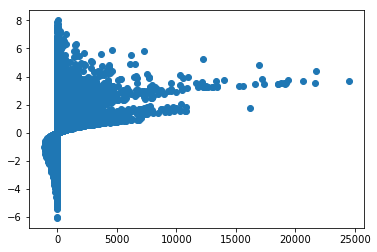

In [72]:
_ = plt.scatter(g_normalized[0].values.flatten(), pmi_normalized[0].values.flatten())

## Prediction of acceptability

Next, given these normalize values, we attempt to predict the normalized acceptability we computed earlier. First, we find the verbs that occur in both MegaAcceptability and VALEX.

In [73]:
shared_verbs = np.intersect1d(acceptability.index.values, verbframe_counts_cast.index.values)

shared_verbs.shape[0]

958

We define a function that will cross-validate a ridge regression, given input predictors (e.g. the normalized counts just computed) and some values to predict (e.g. the normalized acceptabilities).

In [74]:
def run_cross_validation(X, Y):
    """Cross-validate a ridge regression
    
    Parameters
    ----------
    X : numpy.array
        The predictors
    Y : numpy.array
        The values to predict
        
    Returns
    -------
    predictions: list[pandas.DataFrame]
    cv_scores: list[numpy.array]
    """
    kf = KFold(10, random_state=203948, shuffle=True)

    predictions = []
    cv_scores = []

    for i, (train_idx, test_idx) in enumerate(kf.split(Y)):
        reg = RidgeCV(cv=10, alphas=[1e-2, 1e-1, 0.2, 0.5, 1, 2, 5, 10])

        reg.fit(X.iloc[train_idx], 
                Y.iloc[train_idx])

        pred = reg.predict(X.iloc[test_idx])

        predictions.append(pd.DataFrame(pred, 
                                        index=Y.iloc[test_idx].index, 
                                        columns=Y.iloc[test_idx].columns))

        cv_scores.append(reg.score(X.iloc[test_idx],
                                   Y.iloc[test_idx])) 
        
    return predictions, cv_scores

The values to predict will always be the normalized acceptabilities.

In [75]:
Y = acceptability.loc[shared_verbs]

We run this cross-validation, using the values from each of our normalization methods as predictors.

In [76]:
if 'scores_normalized.pkl' in os.listdir(os.path.join(os.getcwd(), 'data')):
    print('Loading scores_dircat, scores_negbin, scores_pmi, and scores_g from cache...')
    
    with open('data/scores_normalized.pkl', 'rb') as f:
        scores_dircat, scores_negbin, scores_pmi, scores_g = pickle.load(f)

else:
    scores_dircat = {s: run_cross_validation(X.loc[shared_verbs], Y) 
                     for s, X in dircat_normalized.items()}

    scores_negbin = {s: run_cross_validation(X.loc[shared_verbs], Y)  
                     for s, X in negbin_normalized.items()}

    scores_pmi = {s: run_cross_validation(X.loc[shared_verbs], Y)
                  for s, X in pmi_normalized.items()}

    scores_g = {s: run_cross_validation(X.loc[shared_verbs], Y)  
                for s, X in g_normalized.items()}
    
    with open('data/scores_normalized.pkl', 'wb') as f:
        pickle.dump([scores_dircat, scores_negbin, scores_pmi, scores_g], f)

Loading scores_dircat, scores_negbin, scores_pmi, and scores_g from cache...


Then, we bootstrap confidence intervals for the mean performance of each model with each hyperparameter setting.

In [77]:
dircat_boot = {s: [np.mean(np.random.choice(sc, size=len(sc), replace=True)) 
                   for _ in range(999)] 
               for s, (_, sc) in scores_dircat.items()}
negbin_boot = {s: [np.mean(np.random.choice(sc, size=len(sc), replace=True)) 
                   for _ in range(999)] 
               for s, (_, sc) in scores_negbin.items()}
pmi_boot = {s: [np.mean(np.random.choice(sc, size=len(sc), replace=True)) 
                for _ in range(999)] 
            for s, (_, sc) in scores_pmi.items()}
g_boot = {s: [np.mean(np.random.choice(sc, size=len(sc), replace=True)) 
              for _ in range(999)] 
          for s, (_, sc) in scores_g.items()}

Finally, we place these results in a data frame for plotting.

In [78]:
pred_stats = {'dircat': pd.DataFrame({s: np.percentile(samps, [2.5, 50, 97.5]) 
                                      for s, samps in dircat_boot.items()}, index=['cilo', 'med', 'cihi']).T,
              'negbin': pd.DataFrame({s: np.percentile(samps, [2.5, 50, 97.5]) 
                                      for s, samps in negbin_boot.items()}, index=['cilo', 'med', 'cihi']).T,
              'pmi': pd.DataFrame({s: np.percentile(samps, [2.5, 50, 97.5]) 
                                   for s, samps in pmi_boot.items()}, index=['cilo', 'med', 'cihi']).T,
              'g': pd.DataFrame({s: np.percentile(samps, [2.5, 50, 97.5]) 
                                 for s, samps in g_boot.items()}, index=['cilo', 'med', 'cihi']).T}

for rep, ps in pred_stats.items():
    ps['rep'] = rep
    
pred_stats = pd.concat(pred_stats.values()).reset_index()

pred_stats

,index,cilo,med,cihi,rep
0,0.0,0.243757,0.257765,0.278405,negbin
1,0.1,0.292608,0.305595,0.321683,negbin
2,0.2,0.283700,0.298354,0.317682,negbin
3,0.5,0.268964,0.284505,0.302414,negbin
4,1.0,0.269011,0.282949,0.301728,negbin
5,2.0,0.272402,0.285408,0.302470,negbin
6,5.0,0.275701,0.285730,0.300195,negbin
7,10.0,0.273042,0.283540,0.299079,negbin
8,20.0,0.268112,0.278820,0.295888,negbin
9,50.0,0.257781,0.270480,0.286832,negbin


Figure 9 of the paper plots these results. We remove $G$ in light of how poor its performance is.

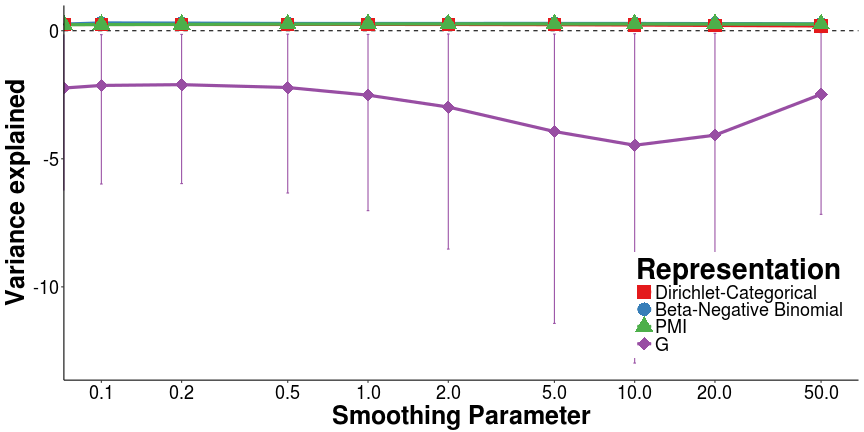

In [79]:
%%R -i pred_stats -w 12 -h 6 -u in

pred_stats$rep <- as.factor(pred_stats$rep)
levels(pred_stats$rep) <- c('Dirichlet-Categorical', 'G', 'Beta-Negative Binomial', 'PMI')
pred_stats$rep <- ordered(pred_stats$rep, levels=c('Dirichlet-Categorical', 'Beta-Negative Binomial', 'PMI', 'G'))

p <- ggplot(pred_stats, aes(x=index, y=med, ymin=cilo, ymax=cihi, color=rep, shape=rep)) + 
geom_hline(yintercept=0, linetype=2) +
geom_errorbar(width=0.01) +
geom_line(size=1.5) +
geom_point(size=6) +
scale_color_brewer(name="Representation", type="qual", palette=6) +
scale_shape_manual(name="Representation", values=c(15,16,17,18)) +
scale_x_log10(name='Smoothing Parameter', breaks=c(0.1, 0.2, 0.5, 1., 2., 5., 10., 20., 50.)) +
scale_y_continuous(name="Variance explained") +
theme(axis.text=element_text(size=18, color="black"),
     axis.title=element_text(size=25, color="black", face="bold"),
     legend.text=element_text(size=18, color="black"),
     legend.title=element_text(size=28, color="black", face="bold"),
     legend.position=c(0.85, 0.2))

p

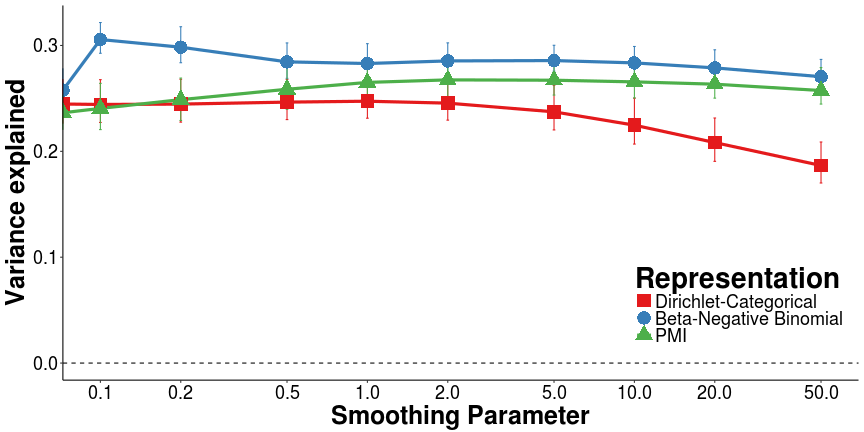

In [80]:
%%R -w 12 -h 6 -u in

p <- ggplot(filter(pred_stats, rep != 'G'), aes(x=index, y=med, ymin=cilo, ymax=cihi, color=rep, shape=rep)) + 
geom_hline(yintercept=0, linetype=2) +
geom_errorbar(width=0.01) +
geom_line(size=1.5) +
geom_point(size=6) +
scale_color_brewer(name="Representation", type="qual", palette=6) +
scale_shape_manual(name="Representation", values=c(15,16,17,18)) +
scale_x_log10(name='Smoothing Parameter', breaks=c(0.1, 0.2, 0.5, 1., 2., 5., 10., 20., 50.)) +
scale_y_continuous(name="Variance explained") +
theme(axis.text=element_text(size=18, color="black"),
     axis.title=element_text(size=25, color="black", face="bold"),
     legend.text=element_text(size=18, color="black"),
     legend.title=element_text(size=28, color="black", face="bold"),
     legend.position=c(0.85, 0.2))

ggsave('plots/varexplained.pdf', width=12, height=6)

p

## Analysis

We investigate two potential predictors of the low performance seen above: variability in judgments and frequency. We might expect variability to positively correlate with error, but it actually negatively correlates.

In [81]:
np.random.seed(10293)

R = (Y - pd.concat(scores_negbin[0.1][0]).loc[Y.index]).abs().reset_index()
V = (-variability.loc[Y.index]).reset_index()

RV = pd.merge(pd.melt(R, id_vars='verb', var_name='frame'), 
              pd.melt(V, id_vars='verb', var_name='frame'),
             on=['verb', 'frame'])


corr_resamp = [spearmanr(RV.sample(frac=1,replace=True)[['value_x', 'value_y']]).correlation for _ in range(999)]

np.round(np.percentile(corr_resamp, [2.5, 50, 97.5]), 3)

array([-0.2  , -0.191, -0.183])

One reason this may come about is that more variable judgments tend to have normalized acceptabilities near the center of the acceptability scale, which arises from the fact that high variability is a consequence of extreme responses from participants that average out to the middle of the scale. Figure 10 of the paper plots this trend.

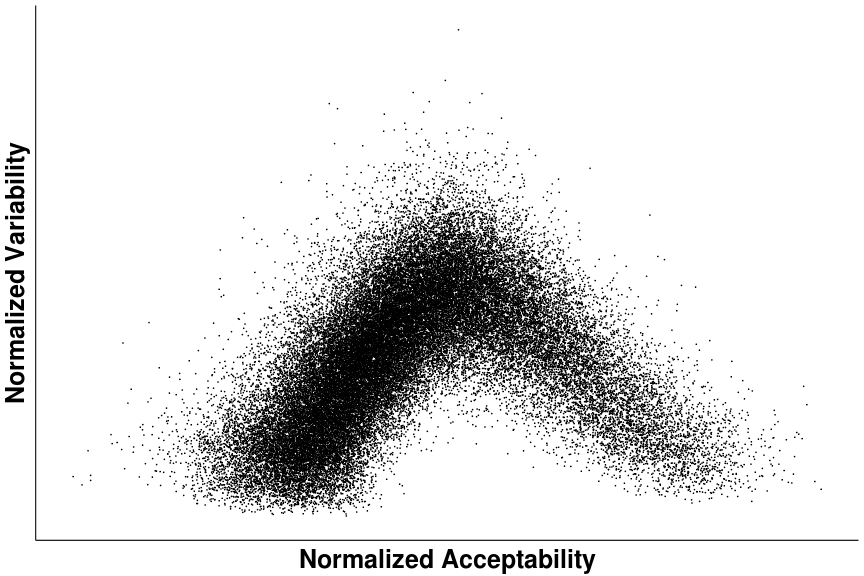

In [82]:
%%R -i normalized -w 12 -h 8 -u in

p <- ggplot(normalized, aes(x=responsenorm, y=-responsevar)) +
geom_point(size=0.05, position=position_jitter(0.25,0.25)) +
xlab('Normalized Acceptability') +
ylab('Normalized Variability') +
theme(axis.ticks=element_blank(), 
      axis.text=element_blank(),
      axis.title=element_text(size=25, face="bold"))

ggsave('plots/value_variability.pdf', width=12, height=8)

p

The poor performance we observe could be due to poor estimates for the distributions of low frequency verbs. In this case, we should expect a negative correlation between verb frequency and models' absolute error. We again test this hypothesis using our best-performing model's absolute error on the held-out data for each fold of the cross-validation. We instead find a reliably positive rank correlation here.

In [83]:
np.random.seed(80203)

F = verbframe_counts_cast.loc[Y.index].sum(axis=1).reset_index()


RF = pd.merge(pd.melt(R, id_vars='verb', var_name='frame'), 
              F,
             on=['verb'])

corr_resamp = [spearmanr(RF.sample(frac=1,replace=True)[['value', 0]]).correlation for _ in range(999)]

np.round(np.percentile(corr_resamp, [2.5, 50, 97.5]), 3)

array([ 0.012,  0.021,  0.03 ])

To see whether these models are making systematic errors, we plot the average error by frame. The result is plotted in Figure 11 in the paper.

In [84]:
np.random.seed(8019)

R = (Y - pd.concat(scores_negbin[0.1][0]).loc[Y.index]).reset_index()

RA = pd.merge(pd.melt(R, id_vars='verb', var_name='frame', value_name='resid'), 
              pd.melt(acceptability.reset_index(), id_vars='verb', var_name='frame', value_name='acc'))

cv_scores_boot = defaultdict(list)

for f, df in RA.groupby('frame'):
    for _ in range(999):
        x = df.sample(frac=1, replace=True)
        cv_scores_boot[f].append(1-np.square(x['resid']).mean()/x['acc'].var())

    cv_scores_boot[f] = np.percentile(cv_scores_boot[f], [2.5, 50, 97.5])

    
cv_scores_boot = pd.DataFrame(cv_scores_boot, index=['cilo', 'med', 'cihi']).T.reset_index()

cv_scores_boot

,index,cilo,med,cihi
0,NP Ved,0.288549,0.340992,0.386611
1,NP Ved NP,0.329754,0.375989,0.417827
2,NP Ved NP VP,0.145556,0.191245,0.232108
3,NP Ved NP VPing,0.264547,0.314671,0.357460
4,NP Ved NP that S,0.061489,0.120772,0.175161
5,NP Ved NP that S[+future],0.093925,0.150591,0.204678
6,NP Ved NP that S[-tense],0.039571,0.080039,0.119565
7,NP Ved NP to NP,0.241174,0.288370,0.329221
8,NP Ved NP to VP[+eventive],0.214679,0.269144,0.317507
9,NP Ved NP to VP[-eventive],0.235301,0.285608,0.331342


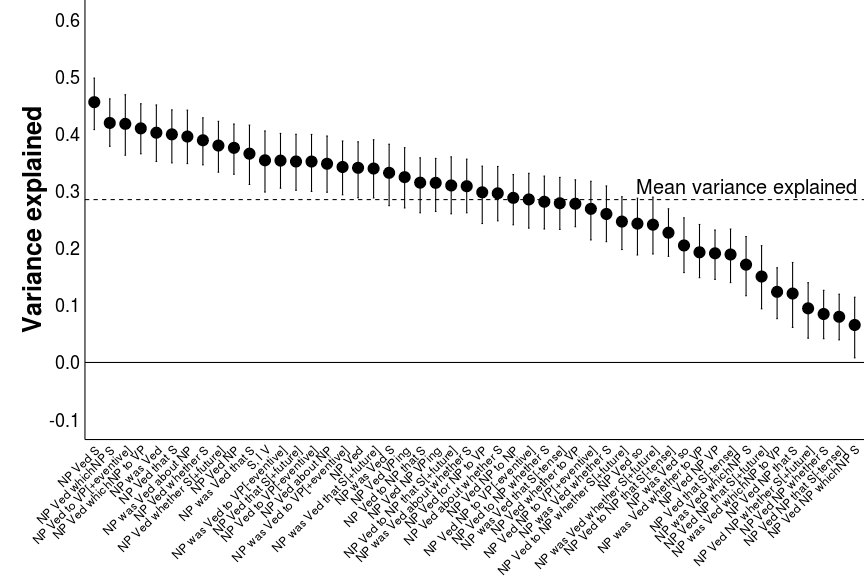

In [85]:
%%R -i cv_scores_boot -w 12 -h 8 -u in

p <- ggplot(cv_scores_boot, aes(x=fct_reorder(index, -med), y=med, ymin=cilo, ymax=cihi)) + 
geom_point(size=5) +
geom_errorbar(width=.1) +
geom_hline(yintercept=0) +
geom_hline(yintercept=mean(cv_scores_boot$med), linetype=2) +
annotate('text', label='Mean variance explained', x=43, y=mean(cv_scores_boot$med)+0.01, size=7, vjust="left") +
scale_y_continuous(name='Variance explained', 
                   breaks=seq(-0.1, 0.6, .1), limits=c(-.1, .6)) +
theme(axis.ticks=element_blank(), 
      axis.text.x=element_text(size=12, angle=45, hjust=1, color="black"),
      axis.title.x=element_blank(), 
      axis.text.y=element_text(size=18, color="black"), 
      axis.title.y=element_text(size=25, face="bold"),
      plot.margin = margin(0, 0, 0, 0.76, "cm"))

ggsave('plots/variance_explained_best.pdf', width=12, height=8)

p

# Abstracting Frequency

Section 6 of the paper presents an investigation of the extent to which various abstractions of frequency distributions represent (are homomorphic to) acceptability.

## Latent Dirichlet Allocation

In Latent Dirichlet Allocation (LDA), we attempt to maximize $\Theta$ and $\Phi$ in:

$$\mathbb{P}(f\;|\;v) = \sum_k\mathbb{P}(f\;|\;k)\mathbb{P}(k\;|\;v) = \sum_k \theta_{vk}\phi_{kf}$$

In [86]:
if 'lda_models.pkl' in os.listdir(os.path.join(os.getcwd(), 'data')):
    print('Loading lda_models from cache...')
    
    with open('data/lda_models.pkl', 'rb') as f:
        lda_models = pickle.load(f)
else:
    lda_models = {k: LatentDirichletAllocation(n_topics=k, 
                                               n_jobs=3, 
                                               learning_method='batch').fit(verbframe_counts_cast) 
                  for k in [2,5,10,15,20,25,30,35,40,45,50]}
    
    with open('data/lda_models.pkl', 'wb') as f:
        pickle.dump(lda_models, f)

Loading lda_models from cache...


We use $\Theta$ from the equation below as our LDA-based distributional representation.

In [87]:
lda_reps = {k: pd.DataFrame(np.concatenate([dircat_normalized[0].loc[shared_verbs],
                                            mod.transform(verbframe_counts_cast.loc[shared_verbs]),
                                            np.dot(mod.transform(verbframe_counts_cast.loc[shared_verbs]),
                                                  mod.components_/mod.components_.sum(axis=0)[None,:])], axis=1), 
                                            index=shared_verbs) 
            for k, mod in lda_models.items()}

## Logistic Factor Analysis

In Logistic Factor Analysis (LFA), we attempt to maximize $\mathbf{U}$ and $\mathbf{V}$ in:

$$\pi_{vf} = \text{logit}^{-1}\left(\sum_k u_{vk}a_{kf}\right)$$

In [88]:
def negbin_factorizer(X, n_components=2, rinit=None, Pinit=None, 
                      tolerance=1e-6, maxiter=30000, verbose=1000, seed=40392):
    """Fit a negative binomial factorizer
    
    Parameters
    ----------
    X : numpy.array[int]
        The counts (object x feature)
    n_components : int
        The beta prior sparsity parameter
    rinit : numpy.array
        The values of r to initialize with
    Pinit : numpy.array
        The values of P to initialize with
    tolerance : float
        The amount of change in loss under which to stop
    maxiter : int
        The maximum number of iterations
    verbose : int
        How often to print the loss
    seed : int
        The random seed
    
    Returns
    -------
    rpos : numpy.array(float)
    U : numpy.array(float)
    V : numpy.array(float)
    Punit : numpy.array(float)
    """
    n_datapoints, n_obsfeats_X = X.shape
    
    # wrap our data in a tensorflow constant
    Xtf = tf.constant(X, dtype=tf.float32)
    
    if rinit is None:
        rinit = tf.truncated_normal((n_datapoints,1), seed=seed)
    else:
        rinit = np.sqrt(rinit)
    
    if Pinit is None:
        Uinit = tf.truncated_normal([n_datapoints, n_components], seed=seed+1)
        Vinit = tf.truncated_normal([n_components, n_obsfeats_X], seed=seed+2)
    else:
        Plogodds = np.log(Pinit) - np.log(1-Pinit)
        pca = PCA().fit(Plogodds)
        Uinit = pca.transform(Plogodds)[:,:n_components]
        Vinit = pca.components_[:n_components]
    
    r = tf.Variable(rinit)
    U = tf.Variable(Uinit)
    V = tf.Variable(Vinit)
    
    rpos = tf.square(r)
    Punit = tf.sigmoid(tf.matmul(U, V))
    #Punit = 1-tf.reduce_prod(1-tf.sigmoid(U)[:,:,None]*tf.sigmoid(V)[None,:,:])
    
    # define the link function
    lognormalizer = tf.lgamma(Xtf+rpos) - tf.lgamma(Xtf+1.) - tf.lgamma(rpos)
    loglike = lognormalizer + rpos*tf.log(1.-Punit+1e-10)+Xtf*tf.log(Punit+1e-10)

    # define the cross entropy (Bernoulli) loss
    loss = -tf.reduce_sum(loglike) 
    
    # define the optimizer
    train_step = tf.train.AdamOptimizer().minimize(loss)
    
    # initialize the variables
    sess.run(tf.global_variables_initializer())
    
    # initialize a variable that will track the loss over iterations
    curr_loss = np.inf
    
    print()
    print('Fitting the beta-negative binomial factorizer with n_components =', n_components)
    print()
    
    for i in range(maxiter):
        train_step.run()
        
        prev_loss = curr_loss
        curr_loss = loss.eval()
        
        finished = (prev_loss - curr_loss) < tolerance
        
        if verbose:
            if not (i % verbose) or finished:
                print('loss:', loss.eval())
                
        if finished:
            break
            
    return rpos.eval(), U.eval(), V.eval(), Punit.eval()

In [89]:
if 'negbin_factorizer_models.pkl' in os.listdir(os.path.join(os.getcwd(), 'data')):
    print('Loading negbin_factorizer_models from cache...')
    
    with open('data/negbin_factorizer_models.pkl', 'rb') as f:
        negbin_factorizer_models = pickle.load(f)

else:
    with tf.Session() as sess:
        negbin_factorizer_models = {k: negbin_factorizer(verbframe_counts_cast.values, 
                                                         n_components=k, seed=40392) 
                                    for k in [2,5,10,15,20,25,30,35,40,45,50]}
        
    with open('data/negbin_factorizer_models.pkl', 'wb') as f:
        pickle.dump(negbin_factorizer_models, f)

Loading negbin_factorizer_models from cache...


We use $\mathbf{U}$ from the equation below as our LFA-based distributional representation.

In [90]:
negbinfact_reps = {k: pd.DataFrame(np.concatenate([negbin_normalized[0.1].values,P,U,r], axis=1), 
                                   index=verbframe_counts_cast.index).loc[shared_verbs] 
                   for k, (r, U, V, P) in negbin_factorizer_models.items()}

## Global Vectors (GloVe)

We employ two verion of GloVe representations: _pretrained_ and _VALEX-based_.

### Pretrained GloVe

For pre-trained GloVe embeddings, we use `glove.42B.300d` available [here](https://nlp.stanford.edu/projects/glove/).

In [91]:
glove_ver = 'glove.42B.300d'

if 'glove_embeddings.tsv' in os.listdir(os.path.join(os.getcwd(), 'data')):
    print('Loading pretrained GloVe embeddings from cache...')
    
    glove_embeddings = pd.read_csv('data/glove_embeddings.tsv', index_col=0, sep='\t')
    
else:
    glove_url = 'http://nlp.stanford.edu/data/' + glove_ver + '.zip'

    if (glove_ver + '.txt') not in os.listdir(os.getcwd()):
        glove_raw = requests.get(glove_url).content

        zipfile.ZipFile(io.BytesIO(glove_raw)).extract(glove_ver + '.txt')

    vocab = np.unique([w.lower() for s in data.sentence.unique() for w in s.split()])

    with open(glove_ver + '.txt') as f:
        emb = np.array([l.strip().split()
                        for l in f
                        if l.split()[0] in vocab])

    glove_embeddings = pd.DataFrame(emb[:,1:].astype(float),
                                    index=emb[:,0])
    
    glove_embeddings.to_csv('data/glove_embeddings.tsv', sep='\t')

Loading pretrained GloVe embeddings from cache...


Only three words do not occur in GloVe.

In [92]:
diff = set(np.setdiff1d([w for v in data.verbform.unique() for w in v.split()], glove_embeddings.index.values))

diff

{'disprefer', 'disprefered', 'snivelled'}

To derive the embedding for a particular sentence in MegaAcceptability, we obtain the embedding for each word in the sentence, then take the mean for each dimension across those embeddings. If a word is not in GloVe, we simply filter that word from the sentence.

In [93]:
def build_glove_sentence_embedding(sentence):
    sentence_split = [w for w in sentence.split() if w not in diff]
    
    emb = glove_embeddings.loc[sentence_split].mean(axis=0)
    assert not emb.isnull().any()
    
    return np.array(emb)

data['verbidx'] = data['verbidx'].map(lambda x: '_'.join([str(i) for i in x]))
condition_sentence_map = data[['verb', 'frame', 'sentence', 'verbidx']].drop_duplicates()
condition_sentence_map['glove_embedding'] = condition_sentence_map.sentence.map(build_glove_sentence_embedding)

We place the resulting sentence embeddings in a dataframe with a row for each verb-frame pair.

In [94]:
acc_glove = pd.merge(pd.melt(acceptability.reset_index(), id_vars='verb', var_name='frame', value_name='acc'),
                     condition_sentence_map[['verb', 'frame', 'glove_embedding']])

acc_glove

,verb,frame,acc,glove_embedding
0,abhor,NP Ved,0.937020,"[-0.04786, 0.0258869, -0.10447, -0.25833, -0.1..."
1,absolve,NP Ved,-0.663034,"[0.11877, -0.0656281, -0.062125, -0.1042395, -..."
2,accept,NP Ved,3.408551,"[-0.10104, -0.1728531, 0.21069, -0.011636, -0...."
3,acclaim,NP Ved,0.787558,"[-0.05882, 0.2217319, 0.1250095, -0.012879, -0..."
4,accredit,NP Ved,-0.146072,"[0.0795315, 0.2002919, -0.23688, -0.42149, -0...."
5,acknowledge,NP Ved,1.332819,"[-0.02785, 0.1102419, 0.25402, -0.0218085, -0...."
6,add,NP Ved,1.226858,"[0.16171, -0.1339731, 0.32871, -0.014354, 0.26..."
7,address,NP Ved,-0.154593,"[0.15233, -0.1307881, 0.614815, 0.056685, 0.07..."
8,admire,NP Ved,1.751948,"[0.05831265, 0.1849919, 0.013625, -0.31379, 0...."
9,admit,NP Ved,1.174871,"[-0.193635, 0.1313219, -0.110915, 0.0934, -0.1..."


### GloVe on VALEX

Beyond pretrained GloVe embeddings, we also train our own GloVe embeddings on top of VALEX. This involves maximizing $\mathbf{W}, \mathbf{W'}, \mathbf{b}, \mathbf{b'}$ in:

$$\mathbb{P}(c_{ij}\;|\;\mathbf{W}, \mathbf{W'}, \mathbf{b}, \mathbf{b'}) = \mathcal{N}(\log\;c_{ij}; \mathbf{w}_i \cdot \mathbf{w'}_j + b_i + b'_j)$$

GloVe has two hyperparameters beyond the number of latent components in $\mathbf{W}, \mathbf{W'}$: a cutoff frequency and a parameter $\alpha$. These serve to downweight the contributions of low frequency words by a factor of $f(c_{ij}) = \min\left(1, \frac{c_{ij}}{c_\text{cutoff}}\right)^{\alpha}$. In the pretrained models (above), $c_\text{cutoff}$ is set 100 and $\alpha$ is set to $\frac{3}{4}$. In the models we train ourselves (below), we set $c_\text{cutoff}$ to 10 and retain the same $\alpha$, since VALEX contains an order of magnitude fewer observations than the cooccurrence matrices pretrained GloVe is trained on.

In [95]:
def fit_glove(X, n_components=2, cutoff=10, alpha=3/4, tolerance=1e-6, maxiter=30000, verbose=1000, seed=66703):
    """Fit global vectors
    
    Parameters
    ----------
    X : numpy.array
        The cooccurrence counts
    n_components : int
        The number of latent components
    cutoff : int
        The cutoff frequency
    alpha : float
        The amount to downweight counts below the cutoff
    tolerance : float
        The amount of change in loss under which to stop
    maxiter : int
        The maximum number of iterations
    verbose : int
        How often to print the loss
    seed : int
        The random seed
    
    Returns
    -------
    W1 : numpy.array
    W2 : numpy.array
    b1 : numpy.array
    b2 : numpy.array
    """
    n_datapoints, n_obsfeats_X = X.shape
    
    # wrap our data in a tensorflow constant
    Xtf = tf.constant(X, dtype=tf.float32)
    Xcutoff = tf.constant(np.where(X>=cutoff, 1, np.power(X/cutoff, alpha)), dtype=tf.float32)
    
    b1init = tf.truncated_normal((n_datapoints,1), seed=seed)
    b2init = tf.truncated_normal((1,n_obsfeats_X), seed=seed+1)

    W1init = tf.truncated_normal([n_datapoints, n_components], seed=seed+2)
    W2init = tf.truncated_normal([n_components, n_obsfeats_X], seed=seed+3)

    b1 = tf.Variable(b1init)
    b2 = tf.Variable(b2init)
    W1 = tf.Variable(W1init)
    W2 = tf.Variable(W2init)

    # define the cross entropy (Bernoulli) loss (eq. 8 in the GloVe paper)
    loss = tf.reduce_mean(Xcutoff*tf.square(tf.matmul(W1, W2) + b1 + b2 - tf.log(Xtf+1e-10))) 
    
    # define the optimizer
    train_step = tf.train.AdamOptimizer().minimize(loss)
    
    # initialize the variables
    sess.run(tf.global_variables_initializer())
    
    # initialize a variable that will track the loss over iterations
    curr_loss = np.inf
    
    print()
    print('Fitting GloVe embedding with n_components =', n_components)
    print()
    
    for i in range(maxiter):
        train_step.run()
        
        prev_loss = curr_loss
        curr_loss = loss.eval()
        
        finished = (prev_loss - curr_loss) < tolerance
        
        if verbose:
            if not (i % verbose) or finished:
                print('loss:', loss.eval())
                
        if finished:
            break
            
    return W1.eval(), W2.eval(), b1.eval(), b2.eval()

In [96]:
if 'glove_models.pkl' in os.listdir(os.path.join(os.getcwd(), 'data')):
    with open('data/glove_models.pkl', 'rb') as f:
        glove_models = pickle.load(f)

else:
    with tf.Session() as sess:
        glove_models = {k: fit_glove(verbframe_counts_cast.values, n_components=k) 
                        for k in [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]}
        
    with open('data/glove_models.pkl', 'wb') as f:
        pickle.dump(glove_models, f)

We then use $\mathbf{W}$ and $\mathbf{b}$ as our GloVe-based distributional representation.

In [97]:
glovevalex_reps = {k: pd.DataFrame(np.concatenate([W1, b1], axis=1), index=verbframe_counts_cast.index)
                   for k, (W1, W2, b1, b2) in glove_models.items()}

### BERT

For our [BERT](https://github.com/google-research/bert)-based representations, we use `bert-base-uncased`, available through the [`huggingface / transformers`](https://github.com/huggingface/transformers) library.

First, we load the pre-trained model tokenizer.

In [98]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Then, we load the weights...

In [99]:
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=

...and construct the sentence embeddings. As is standard practice, we use the embedding for `[CLS]` as the sentence representation.

In [100]:
def get_bert_embedding(sentence):
    tokens = tokenizer.tokenize('[CLS] ' + sentence + ' [SEP]')
    
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    token_ids_t = torch.tensor([token_ids])

    embeddings = model(token_ids_t, output_all_encoded_layers=False)[0]
    
    return embeddings[:,0].detach().numpy()

if 'bert_embeddings.pkl' in os.listdir(os.path.join(os.getcwd(), 'data')):
    with open('data/bert_embeddings.pkl', 'rb') as f:
        bert_embeddings = pickle.load(f)

else:
    bert_embeddings = condition_sentence_map.sentence.apply(get_bert_embedding)

    with open('data/bert_embeddings.pkl', 'wb') as f:
        pickle.dump(bert_embeddings, f)
    
condition_sentence_map['bert_embedding'] = bert_embeddings

We place the resulting sentence embeddings in a dataframe with a row for each verb-frame pair.

In [101]:
acc_bert = pd.merge(pd.melt(acceptability.reset_index(), id_vars='verb', var_name='frame', value_name='acc'),
                     condition_sentence_map[['verb', 'frame', 'bert_embedding']])

acc_bert.head()

,verb,frame,acc,bert_embedding
0,abhor,NP Ved,0.937020,"[[-0.411784, 0.10321, -0.551622, 0.127735, -0...."
1,absolve,NP Ved,-0.663034,"[[-0.31142, -0.0538474, -0.166839, 0.141852, -..."
2,accept,NP Ved,3.408551,"[[-0.439822, -0.11092, -0.122514, 0.190875, -0..."
3,acclaim,NP Ved,0.787558,"[[-0.487923, -0.0693498, -0.347534, 0.0525596,..."
4,accredit,NP Ved,-0.146072,"[[-0.277549, 0.122841, -0.163947, 0.129582, -0..."


## Predicting acceptability

Predicting acceptability based on the abstracted representations follows the same course as for the representations in the previous section. We first run the cross-validated ridge regression for each representation.

In [102]:
if 'scores_abstracted.pkl' in os.listdir(os.path.join(os.getcwd(), 'data')):
    print('Loading scores_lda, scores_negbinfact, scores_glovevalex, scores_glove, and scores_bert from cache...')
    
    with open('data/scores_abstracted.pkl', 'rb') as f:
        scores_lda, scores_negbinfact, scores_glovevalex, scores_glove, scores_bert = pickle.load(f)

else:
    scores_lda = {k: run_cross_validation(X, Y)
              for k, X in lda_reps.items()}
    scores_negbinfact = {k: run_cross_validation(X, Y)  
                         for k, X in negbinfact_reps.items()}
    scores_glovevalex = {k: run_cross_validation(X.loc[shared_verbs], Y)  
                         for k, X in glovevalex_reps.items()}
    scores_glove = run_cross_validation(pd.DataFrame(np.array(list(acc_glove.glove_embedding.values))), 
                                        acc_glove[['acc']])
    scores_bert = run_cross_validation(pd.DataFrame(np.concatenate(list(acc_bert.bert_embedding.values))),
                                       acc_bert[['acc']])
    
    with open('data/scores_abstracted.pkl', 'wb') as f:
        pickle.dump([scores_lda, scores_negbinfact, scores_glovevalex, scores_glove, scores_bert], f)


Loading scores_lda, scores_negbinfact, scores_glovevalex, scores_glove, and scores_bert from cache...


We then bootstrap the mean scores for each of those regressions.

In [103]:
lda_boot = {s: [np.mean(np.random.choice(sc, size=len(sc), replace=True)) 
                for _ in range(999)] 
            for s, (_, sc) in scores_lda.items()}
negbinfact_boot = {s: [np.mean(np.random.choice(sc, size=len(sc), replace=True)) 
                       for _ in range(999)] 
                   for s, (_, sc) in scores_negbinfact.items()}
glovevalex_boot = {s: [np.mean(np.random.choice(sc, size=len(sc), replace=True)) 
                       for _ in range(999)] 
                   for s, (_, sc) in scores_glovevalex.items()}
glove_boot = {0: [np.mean(np.random.choice(scores_glove[1], size=len(scores_glove[1]), replace=True)) 
                  for _ in range(999)]}
bert_boot = {0: [np.mean(np.random.choice(scores_bert[1], size=len(scores_bert[1]), replace=True)) 
                 for _ in range(999)]}

Since only LDA, LFA, and the version of GloVe that we train on VALEX have multiple values for the representation size, only those models' results are entered into a dataframe.

In [104]:
pred_stats = {'lda': pd.DataFrame({s: np.percentile(samps, [2.5, 50, 97.5]) 
                                   for s, samps in lda_boot.items()}, 
                                  index=['cilo', 'med', 'cihi']).T,
              'negbinfact': pd.DataFrame({s: np.percentile(samps, [2.5, 50, 97.5]) 
                                          for s, samps in negbinfact_boot.items()}, 
                                         index=['cilo', 'med', 'cihi']).T,
             'glovevalex': pd.DataFrame({s: np.percentile(samps, [2.5, 50, 97.5]) 
                                         for s, samps in glovevalex_boot.items()}, 
                                        index=['cilo', 'med', 'cihi']).T}

for rep, ps in pred_stats.items():
    ps['rep'] = rep
    
pred_stats = pd.concat(pred_stats.values()).reset_index()

pred_stats

,index,cilo,med,cihi,rep
0,2,0.100765,0.113268,0.122789,glovevalex
1,5,0.158705,0.174949,0.192735,glovevalex
2,10,0.216782,0.228908,0.245785,glovevalex
3,15,0.232357,0.247210,0.263778,glovevalex
4,20,0.221606,0.237301,0.257398,glovevalex
5,25,0.204816,0.222956,0.241238,glovevalex
6,30,0.205221,0.224535,0.240559,glovevalex
7,35,0.190236,0.209945,0.224345,glovevalex
8,40,0.191130,0.201564,0.210427,glovevalex
9,45,0.182331,0.193842,0.205632,glovevalex


We look at the performance of pretrained GloVe and BERT directly. The median values below are used to determine the placement of the corresponding dashed lines in the plot.

In [105]:
np.percentile(glove_boot[0], [2.5, 50, 97.5]), np.percentile(bert_boot[0], [2.5, 50, 97.5])

(array([ 0.20122386,  0.20544992,  0.21007123]),
 array([ 0.55317793,  0.55726652,  0.5609015 ]))

Figure 12 of the paper plots the comparison between the abstracted models.

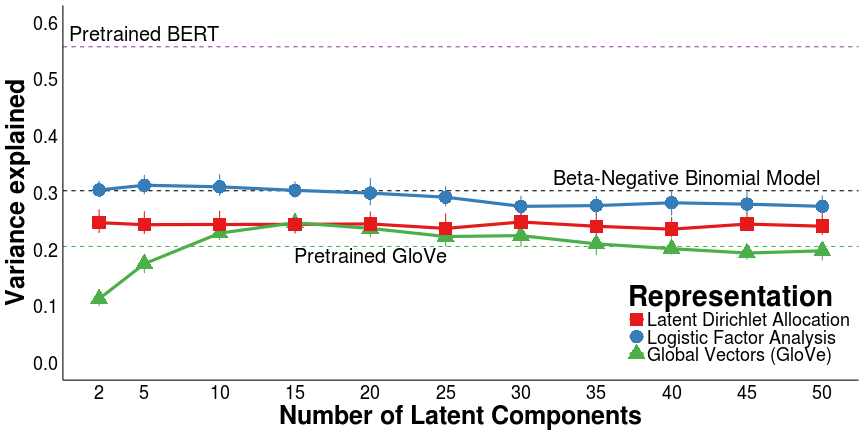

In [106]:
%%R -i pred_stats -w 12 -h 6 -u in

pred_stats$rep <- as.factor(pred_stats$rep)
levels(pred_stats$rep) <- c('Global Vectors (GloVe)', 'Latent Dirichlet Allocation', 'Logistic Factor Analysis')
pred_stats$rep <- ordered(pred_stats$rep, levels=c('Latent Dirichlet Allocation', 'Logistic Factor Analysis', 'Global Vectors (GloVe)'))

p <- ggplot(pred_stats, aes(x=index, y=med, ymin=cilo, ymax=cihi, color=rep, shape=rep)) + 
geom_hline(yintercept=0.303673, linetype=2) +
geom_hline(yintercept=0.20544992, linetype=2, color="#4daf4a") +
geom_hline(yintercept=0.55726652, linetype=2, color="#984ea3") +
geom_errorbar(width=0.01) +
geom_line(size=1.5) +
geom_point(size=6) +
annotate('text', label="Beta-Negative Binomial Model", x=41, y=0.303673+0.01, size=7, vjust="left") +
annotate('text', label='Pretrained GloVe', x=20, y=0.20544992-0.03, size=7, vjust="left") +
annotate('text', label='Pretrained BERT', x=5, y=0.55726652+0.01, size=7, vjust="left") +
scale_color_brewer(name="Representation", type="qual", palette=6) +
scale_shape_manual(name="Representation", values=c(15,16,17,18)) +
scale_x_continuous(name='Number of Latent Components', breaks=c(2,5,10,15,20,25,30,35,40,45,50)) +
scale_y_continuous(name="Variance explained", limits=c(0, 0.6), breaks=seq(0,.6,.1)) +
theme(axis.text=element_text(size=18, color="black"),
     axis.title=element_text(size=25, color="black", face="bold"),
      axis.ticks=element_blank(),
     legend.text=element_text(size=18, color="black"),
     legend.title=element_text(size=28, color="black", face="bold"),
     legend.position=c(0.85, 0.15))

ggsave('plots/abstraction_models.pdf', width=12, height=6)

p

In [107]:
accpred_bert = pd.merge(acc_bert.drop('bert_embedding', axis=1), pd.concat(scores_bert[0]),
                        left_index=True, right_index=True)

accpred_bert

,verb,frame,acc_x,acc_y
13,advise,NP Ved,1.925332,1.614129
23,agree,NP Ved,2.959139,2.687891
25,alarm,NP Ved,0.377242,0.777667
40,apologize,NP Ved,4.199326,2.320759
44,appease,NP Ved,0.514293,0.217727
67,audit,NP Ved,0.943255,2.351328
80,bear,NP Ved,-1.258716,0.119086
83,begin,NP Ved,1.614970,0.488307
88,bet,NP Ved,2.057148,0.951113
93,blare,NP Ved,1.040158,1.329102


Finally, to understand where BERT predicts well and where it predicts poorly, we plot the average error by frame. The result is plotted in Figure 13 in the paper.

In [108]:
def boot_r2(x):
    scores = []
    for _ in range(999):
        x_resamp = x.sample(frac=1, replace=True)

        scores.append(np.mean(np.square(x_resamp.acc_x-x_resamp.acc_y))/x_resamp.acc_x.var())
  
    return list(np.percentile(scores, [2.5, 50, 97.5]))

bert_boot_frame = accpred_bert.groupby('frame')[['acc_x', 'acc_y']].apply(boot_r2).reset_index()

bert_boot_frame['cilo'] = bert_boot_frame[0].map(lambda x: x[0])
bert_boot_frame['med'] = bert_boot_frame[0].map(lambda x: x[1])
bert_boot_frame['cihi'] = bert_boot_frame[0].map(lambda x: x[2])

bert_boot_frame = bert_boot_frame.drop(0, axis=1)

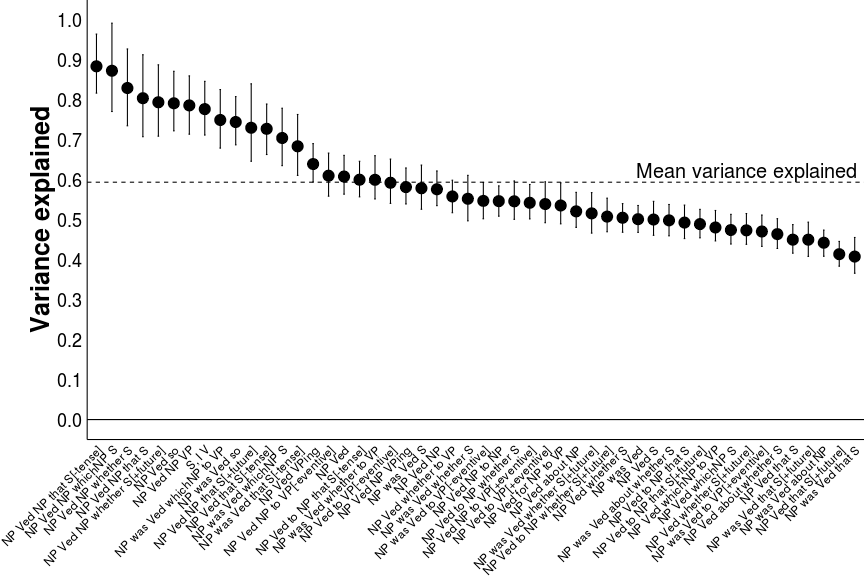

In [109]:
%%R -i bert_boot_frame -w 12 -h 8 -u in

p <- ggplot(bert_boot_frame, aes(x=fct_reorder(frame, -med), y=med, ymin=cilo, ymax=cihi)) + 
geom_point(size=5) +
geom_errorbar(width=.1) +
geom_hline(yintercept=0) +
geom_hline(yintercept=mean(bert_boot_frame$med), linetype=2) +
annotate('text', label='Mean variance explained', x=43, y=mean(bert_boot_frame$med)+0.01, size=7, vjust="left") +
scale_y_continuous(name='Variance explained', 
                   breaks=seq(0, 1, .1), limits=c(0, 1)) +
theme(axis.ticks=element_blank(), 
      axis.text.x=element_text(size=12, angle=45, hjust=1, color="black"),
      axis.title.x=element_blank(), 
      axis.text.y=element_text(size=18, color="black"), 
      axis.title.y=element_text(size=25, face="bold"),
      plot.margin = margin(0, 0, 0, 1.05, "cm"))

ggsave('plots/variance_explained_bert_frame.pdf', width=12, height=8)

p

# Single Verb

In Appendix D, we decribe a method for straighforwardly adding predicates that are not included in the original dataset on at a time. 

In [110]:
singleverb_url = 'http://megaattitude.io/projects/mega-acceptability/mega-acceptability-singleverb-v1/mega-acceptability-singleverb-v1.tsv'

data_singleverb = pd.read_csv(singleverb_url, sep='\t')

data_singleverb.head()

,participant,list,presentationorder,verb,frame,response,nativeenglish,sentence
0,15,1,1,say,NP Ved NP,7,True,Someone said something.
1,15,1,2,say,NP was Ved,2,True,Someone was said.
2,15,1,3,say,NP Ved,5,True,Someone said.
3,15,1,4,say,NP Ved NP whichNP S,2,True,Someone said someone which thing happened.
4,15,1,5,say,NP Ved so,7,True,Someone said so.


This dataset contains the 30 verbs from the validation experiments...

In [111]:
old_verbs = np.intersect1d(data_singleverb.verb.unique(), data.verb.unique())

old_verbs

array(['allow', 'amaze', 'believe', 'bother', 'demand', 'deny', 'doubt',
       'expect', 'feel', 'forbid', 'forget', 'guess', 'hate', 'hear',
       'hope', 'imagine', 'love', 'need', 'pretend', 'promise', 'realize',
       'remember', 'say', 'see', 'suppose', 'tell', 'think', 'understand',
       'want', 'worry'], dtype=object)

As well as seven that were unintentionally excluded from the MegaAcceptability dataset.

In [112]:
new_verbs = np.setdiff1d(data_singleverb.verb.unique(), data.verb.unique())

new_verbs

array(['deserve', 'fail', 'help', 'manage', 'neglect', 'opt', 'refuse'], dtype=object)

We preprocess the data in the same way as we did for the MegaAcceptability data.

In [113]:
data_singleverb['sentence'] = data_singleverb.sentence.str.replace('-', '')
data_singleverb['sentence'] = data_singleverb.sentence.str.replace('.', ' .')
data_singleverb['sentence'] = data_singleverb.sentence.str.replace(',', ' ,')
data_singleverb['sentence'] = data_singleverb.sentence.str.replace('_', ' ')

data_singleverb['verbidx'] = data_singleverb[['sentence', 'frame', 'verb']].apply(lambda x: get_idx(*x), axis=1)
data_singleverb['verbform'] = data_singleverb[['sentence', 'verbidx']].apply(lambda x: get_verb_form(*x), axis=1)

In [114]:
data_singleverb['response'] = data_singleverb['response'].astype('int')
data_singleverb['framevoice'] = data_singleverb['frame'].astype('category')
data_singleverb['verbframevoice'] = (data_singleverb['verb'] + '-' +\
                          data_singleverb['frame']).astype('category')
data_singleverb['participant'] = data_singleverb['participant'].astype('category')

data_singleverb.head()

,participant,list,presentationorder,verb,frame,response,nativeenglish,sentence,verbidx,verbform,framevoice,verbframevoice
0,15,1,1,say,NP Ved NP,7,True,Someone said something .,[1],said,NP Ved NP,say-NP Ved NP
1,15,1,2,say,NP was Ved,2,True,Someone was said .,[2],said,NP was Ved,say-NP was Ved
2,15,1,3,say,NP Ved,5,True,Someone said .,[1],said,NP Ved,say-NP Ved
3,15,1,4,say,NP Ved NP whichNP S,2,True,Someone said someone which thing happened .,[1],said,NP Ved NP whichNP S,say-NP Ved NP whichNP S
4,15,1,5,say,NP Ved so,7,True,Someone said so .,[1],said,NP Ved so,say-NP Ved so


In [115]:
corrs_bulk_df_old = compute_correlation_by_list(data_singleverb[data_singleverb.verb.isin(old_verbs)], 
                                                'verbframevoice', 'list')

corrs_bulk_df_old.head()

,list,subject1,subject2,corr
0,1,15,21,0.655077
1,1,21,15,0.655077
2,1,15,23,0.733565
3,1,23,15,0.733565
4,1,15,5,0.713929


In [116]:
np.random.seed(40392)

corrs_bulk_mean_boot = np.array([corrs_bulk_df_old['corr'].sample(frac=1, replace=True).mean() 
                                 for _ in range(999)])
corrs_bulk_median_boot = np.array([corrs_bulk_df_old['corr'].sample(frac=1, replace=True).median() 
                                   for _ in range(999)])

np.round(np.percentile(corrs_bulk_median_boot, [2.5, 50, 97.5]), 3)

array([ 0.63 ,  0.649,  0.666])

In [117]:
corrs_bulk_df = compute_correlation_by_list(data_singleverb, 'verbframevoice', 'list')

corrs_bulk_df.head()

,list,subject1,subject2,corr
0,1,15,21,0.655077
1,1,21,15,0.655077
2,1,15,23,0.733565
3,1,23,15,0.733565
4,1,15,5,0.713929


In [118]:
%%R -i corrs_bulk_df -o subj_qual

m <- lmer(corr ~ 1 + (1|subject1) + (1|list), data=corrs_bulk_df)

subj_qual <- as.data.frame(ranef(m)$subject1)
subj_qual$subj <- row.names(subj_qual)
names(subj_qual) <- c('agreement', 'participant')

summary(m)

Linear mixed model fit by REML ['lmerMod']
Formula: corr ~ 1 + (1 | subject1) + (1 | list)
   Data: corrs_bulk_df

REML criterion at convergence: -330.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8656 -0.3361  0.1341  0.6272  1.8051 

Random effects:
 Groups   Name        Variance Std.Dev.
 list     (Intercept) 0.006728 0.08203 
 subject1 (Intercept) 0.015380 0.12402 
 Residual             0.032030 0.17897 
Number of obs: 740, groups:  list, 37; subject1, 29

Fixed effects:
            Estimate Std. Error t value
(Intercept)  0.54588    0.02974   18.36


In [119]:
subj_qual['agreement_norm'] = subj_qual['agreement']/subj_qual['agreement'].std()
subj_qual['participant'] = subj_qual['participant'].astype(int).astype('category')

data_singleverb = pd.merge(data_singleverb, subj_qual, on='participant')

In [120]:
if 'mega-attitude-singleverb-v1.tsv' in os.listdir(os.path.join(os.getcwd(), 'data')):
    print('Reloading single verb data with normalization from cache...')
    data_singleverb = pd.read_csv('data/mega-attitude-singleverb-v1.tsv', sep='\t')

else:
    with tf.Session() as sess:
        normed_sv = fit_normalizer(data_singleverb.response-1,
                                   data_singleverb.verbframevoice.astype('category').cat.codes.values,
                                   data_singleverb.participant.astype('category').cat.codes,
                                   weights=sp.stats.norm.cdf(data_singleverb.agreement_norm.values))

    data_singleverb['responsenorm'], data_singleverb['responselike'], _, _ = normed_sv
    
    data_singleverb.to_csv('data/mega-attitude-singleverb-v1.tsv', index=False, sep='\t')

Reloading single verb data with normalization from cache...


In [121]:
acceptability_singleverb = data_singleverb.pivot_table(index='verb', 
                                                       columns='framevoice', 
                                                       values='responsenorm')

acceptability_singleverb.head()

framevoice,NP Ved,NP Ved NP,NP Ved NP VP,NP Ved NP VPing,NP Ved NP that S,NP Ved NP that S[+future],NP Ved NP that S[-tense],NP Ved NP to NP,NP Ved NP to VP[+eventive],NP Ved NP to VP[-eventive],...,NP was Ved that S[+future],NP was Ved that S[-tense],NP was Ved to VP[+eventive],NP was Ved to VP[-eventive],NP was Ved whether S,NP was Ved whether S[+future],NP was Ved whether to VP,NP was Ved whichNP S,NP was Ved whichNP to VP,"S, I V"
verb,,,,,,,,,,,,,,,,,,,,,
allow,2.160973,2.909001,1.778566,0.461181,-1.111674,-1.813010,-1.813010,0.752510,3.457564,3.457564,...,-0.474726,-0.657656,3.457587,3.457564,0.103912,-0.066359,0.721769,-0.843162,-0.244832,0.313269
amaze,1.261824,-0.570422,-1.757138,0.622510,-0.194070,-0.860806,-0.672690,-1.757138,-1.246950,-1.757138,...,2.228364,0.705277,0.319805,1.832773,0.540350,-0.038814,-0.860806,0.144567,-0.463965,-1.757138
believe,2.998854,2.998854,-0.894423,0.494119,1.161367,1.335924,-0.709313,-1.858150,-0.471996,0.883512,...,0.368300,-1.095202,1.420438,2.998854,0.394972,0.117633,-0.349754,-0.681125,-0.949563,2.998854
bother,1.328871,1.957452,0.384368,1.700582,-0.331542,-0.381077,-0.985674,-0.351600,1.071612,0.395005,...,2.317336,-0.188854,2.148663,1.000439,0.094335,1.394389,0.827123,-0.544305,0.118402,-1.089692
demand,2.556473,2.951363,1.361466,-0.513534,-1.637559,-0.353639,-0.704552,2.138612,2.271597,2.407049,...,-1.637559,-0.130278,2.271559,0.806261,-0.794661,-1.268168,0.407640,-1.040144,0.888302,0.370252


To investigate agreement by-verb, we cast the normalized data for only the verbs found in the MegaAcceptability dataset (`old_verbs`).

In [122]:
acceptability_singleverb_old = acceptability_singleverb[acceptability_singleverb.index.isin(old_verbs)]

acceptability_singleverb_old

framevoice,NP Ved,NP Ved NP,NP Ved NP VP,NP Ved NP VPing,NP Ved NP that S,NP Ved NP that S[+future],NP Ved NP that S[-tense],NP Ved NP to NP,NP Ved NP to VP[+eventive],NP Ved NP to VP[-eventive],...,NP was Ved that S[+future],NP was Ved that S[-tense],NP was Ved to VP[+eventive],NP was Ved to VP[-eventive],NP was Ved whether S,NP was Ved whether S[+future],NP was Ved whether to VP,NP was Ved whichNP S,NP was Ved whichNP to VP,"S, I V"
verb,,,,,,,,,,,,,,,,,,,,,
allow,2.160973,2.909001,1.778566,0.461181,-1.111674,-1.813010,-1.813010,0.752510,3.457564,3.457564,...,-0.474726,-0.657656,3.457587,3.457564,0.103912,-0.066359,0.721769,-0.843162,-0.244832,0.313269
amaze,1.261824,-0.570422,-1.757138,0.622510,-0.194070,-0.860806,-0.672690,-1.757138,-1.246950,-1.757138,...,2.228364,0.705277,0.319805,1.832773,0.540350,-0.038814,-0.860806,0.144567,-0.463965,-1.757138
believe,2.998854,2.998854,-0.894423,0.494119,1.161367,1.335924,-0.709313,-1.858150,-0.471996,0.883512,...,0.368300,-1.095202,1.420438,2.998854,0.394972,0.117633,-0.349754,-0.681125,-0.949563,2.998854
bother,1.328871,1.957452,0.384368,1.700582,-0.331542,-0.381077,-0.985674,-0.351600,1.071612,0.395005,...,2.317336,-0.188854,2.148663,1.000439,0.094335,1.394389,0.827123,-0.544305,0.118402,-1.089692
demand,2.556473,2.951363,1.361466,-0.513534,-1.637559,-0.353639,-0.704552,2.138612,2.271597,2.407049,...,-1.637559,-0.130278,2.271559,0.806261,-0.794661,-1.268168,0.407640,-1.040144,0.888302,0.370252
deny,1.660259,2.703933,0.017019,0.723529,-0.838706,-0.449801,-1.121857,2.257177,1.257541,0.426050,...,-0.449129,-0.395845,1.231539,1.549373,-0.375269,-0.582650,-0.277796,-1.182871,0.222050,-0.407425
doubt,2.392279,3.141314,-1.459858,-0.186319,-1.459858,-1.459803,-0.566888,-0.366259,-0.427842,-0.040545,...,0.027172,-0.902222,-0.593744,0.792460,0.159236,-0.040545,-0.272399,-0.902222,-1.459803,0.365570
expect,1.957091,2.808819,1.268665,0.792135,-1.673110,-1.673094,-0.792355,0.028232,2.808862,2.808819,...,-0.373699,-1.673094,2.808862,2.209843,-0.848265,-1.673036,-0.768306,-1.673094,-0.958739,2.061990
feel,1.496239,3.095845,-0.969209,0.717457,-0.828911,-1.402461,-1.068142,-0.893505,-0.184134,-0.567577,...,-1.026606,-1.402461,-0.416870,0.452412,-1.402461,-1.402461,-1.402461,-1.402461,-0.774385,1.272285


We then compute the correlation between the normalized values in MegaAcceptability and those from this dataset.

In [123]:
singleverb_verbs_corrs = bootstrap_correlation(acceptability.loc[acceptability_singleverb_old.index, 
                                                                  acceptability_singleverb_old.columns].T, 
                                                 acceptability_singleverb_old.T)
    
singleverb_verbs_corrs.head()

,df1_cols,df2_cols,mean,cilo,cihi
0,allow,allow,0.782029,0.648239,0.881722
1,amaze,allow,-0.026459,-0.302566,0.245417
2,believe,allow,0.421743,0.169261,0.646183
3,bother,allow,0.235101,-0.017070,0.479319
4,demand,allow,0.558873,0.311157,0.747797


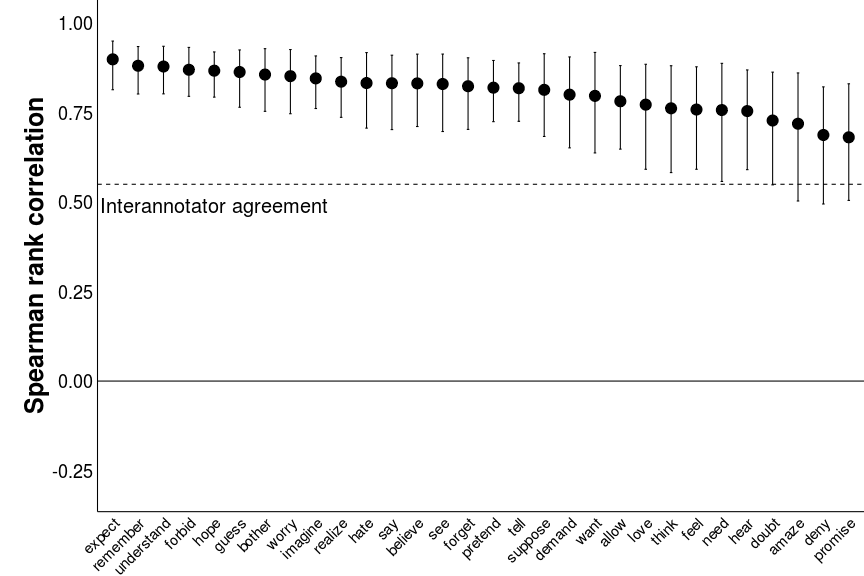

In [124]:
%%R -i singleverb_verbs_corrs -w 12 -h 8 -u in

singleverb_verbs_corrs_sub <- subset(singleverb_verbs_corrs, df1_cols==df2_cols)

p <- ggplot(singleverb_verbs_corrs_sub, 
            aes(x=fct_reorder(df1_cols, -mean), y=mean, ymin=cilo, ymax=cihi)) + 
geom_point(size=5) +
geom_errorbar(width=.1) +
geom_hline(yintercept=0) +
geom_hline(yintercept=0.55, linetype=2) +
annotate('text', label='Interannotator agreement', x=5, y=.47, size=7, vjust="left") +
scale_y_continuous(name='Spearman rank correlation', breaks=c(-.25, 0, .25, .5, .75, 1), limits=c(-.3, 1)) +
theme(axis.ticks=element_blank(), 
      axis.text.x=element_text(size=15, angle=45, hjust=1, color="black"),
      axis.title.x=element_blank(), 
      axis.text.y=element_text(size=18, color="black"), 
      axis.title.y=element_text(size=25, face="bold"),
      plot.margin = margin(0, 0, 0, 0.85, "cm"))

ggsave('plots/singleverb_correlation_verb_point.pdf', width=12, height=8)

p

Finally, we save the normalized values from both MegaAcceptability and the new verbs runs using this method to `mega-acceptability-v1-normalized.tsv`. This file is available [here](http://megaattitude.io/projects/mega-acceptability/mega-acceptability-v1/mega-acceptability-v1-normalized.tsv).

In [125]:
data_singleverb_new = data_singleverb[data_singleverb.verb.isin(new_verbs)]

normalized_singleverb = data_singleverb_new.pivot_table(index=['verb', 'frame'], values='responsenorm').reset_index()
weightedvar_singleverb = data_singleverb_new.groupby(['verb', 'frame'])[['responselike', 'agreement_norm']].apply(lambda x: x.responselike.sum()/sp.stats.norm.cdf(x.agreement_norm).sum()).reset_index().rename(columns={0: 'responsevar'})

normalized_singleverb = pd.merge(normalized_singleverb, weightedvar_singleverb)

normalized_singleverb = pd.merge(normalized_singleverb, data_singleverb_new[['verb', 'verbform', 'frame', 'sentence']].drop_duplicates())
normalized_singleverb = normalized_singleverb[['verb', 'verbform', 'frame', 'sentence', 'responsenorm', 'responsevar']]

normalized_all = pd.concat([normalized, normalized_singleverb])

normalized_all.tail()

,verb,verbform,frame,sentence,responsenorm,responsevar
345,refuse,refused,NP was Ved whether S[+future],Someone was refused whether something would ha...,-0.840208,-1.110817
346,refuse,refused,NP was Ved whether to VP,Someone was refused whether to do something .,-0.522459,-1.057192
347,refuse,refused,NP was Ved whichNP S,Someone was refused which thing happened .,-1.826966,-0.228580
348,refuse,refused,NP was Ved whichNP to VP,Someone was refused which thing to do .,-0.682572,-1.059557
349,refuse,refuse,"S, I V","Something happened , I refuse .",0.057391,-1.945531


In [126]:
normalized_all.to_csv('data/mega-acceptability-v1-normalized.tsv', index=False, sep='\t')